# Fly Flip Notebook
- First label images front and back
Then what we will do and then we can see if they face the front
- First orient all the images so they face the front...
- Second we will take the mean mask and ensure that it is oriented in the center so all masks need to be centered in the image
-

Will then use the average/mean mask as a template. With this template we should be able to compare to the original images and then determine the orientation.

Then will examine effectivness on test dataset..

Phases:
1. Import Depandencies
2. Set Data Source
3. Perform Image Labeling
    - Currently using OpenCV Method
    - Next Method: Using Tkinter GUI
4. Development of Average Mask
5. MSE Comparison
6. Plot of MSE

## Import Libraries

In [1]:
# Import Libraries
import sys
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import copy
import glob
import tkinter as tk
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
# plot_dir = os.path.join(current_dir,'plotting')
sys.path.append(current_dir)
# print(sys.path)
# Import libraries regarding the trace...
from flyplot.parsing import basic_sections as bsc_sec # basic data parsing methods
from flyplot.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from flyplot.parsing.exact_exp_groups import sub_exp_group,sub_exp_groupv2  # more dataparsing methods
from flyplot.led_convert import get_LED_angle_in_rad
from flyplot.plotting import polarplot as polarplt # polar plotting module
from flyplot.parsing import basic_sections as bsc_sec # basic data parsing methods
from flyplot.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from flyplot.parsing.exact_exp_groups import sub_exp_group  # more dataparsing methods
from flyplot.led_convert import get_LED_angle_in_rad
from flyplot.plotting.flyviz import get_contour_centroid, get_objectmask, get_fill_flymask, contour_hrz_matrix
from flyplot.data.data_loader import data_loader
 # import example data
# from scipy import interpolate
from find_fly_angle.find_fly_anglev2 import *

/home/loganrower/project_repos/flyplot/flyplot
Initializing Fly Plot Modules
Initialized Parsing Package
Initialized Plotting Package
flyplot load sample data


## Set Data Source

Provide path to the image and text dataset that will be referenced throughout this notebook.

Examples:

* MacOS
    
    `data = glob.glob('/Volumes/No Name/20240502125110/*.png')`

* Windows

    `data = glob.glob('D:/20240502125110/*.png')`
    
    
* Linux

    `data = glob.glob('/media/user_name/D5E2-7968/20240502125110/*.png')`

In [2]:
imgs_source = '/media/loganrower/D5E2-7968/20240502125110/*.png'

In [3]:
txt_source = '/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt'

In [4]:
# Path to Image Dataset
img_data = glob.glob(imgs_source)
# Path to Text Data
txt_data = txt_source  

Determine the number of images in the dataset

In [5]:
len(img_data)

8862

## (Optional) Test Image

To ensure that all dependancies are working appropriately, an image source internally within this package will be used to test the `contour_hrz_matrix` method.

Alternatively, you can utilize a different image.

In [6]:
# Load in Example Data:
sample_figs = data_loader()['figs']
sample_imgs = data_loader()['imgs']
sample_raw_dat =data_loader()['raw_data']
# Example Image:
file = '20240502125110_7355' # 5244
file_name = None
for img in sample_imgs:
    if  img.strip('.png').split('/')[-1]== file:
        file_name = img
# file ="20240415120905_0121" 
# file_name = "imgs/" + file +".png"
fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz, angle_og, angle_rot = contour_hrz_matrix(file_name)


Angle: 71.60198091314216 71.60198091314216
Est Rotated Angle: -108.39801908685786 -1.8919023357053266
Angle: 90.0536226428922 90.05362264289221
Est Rotated Angle: -89.94637735710779 -1.5698604351228065


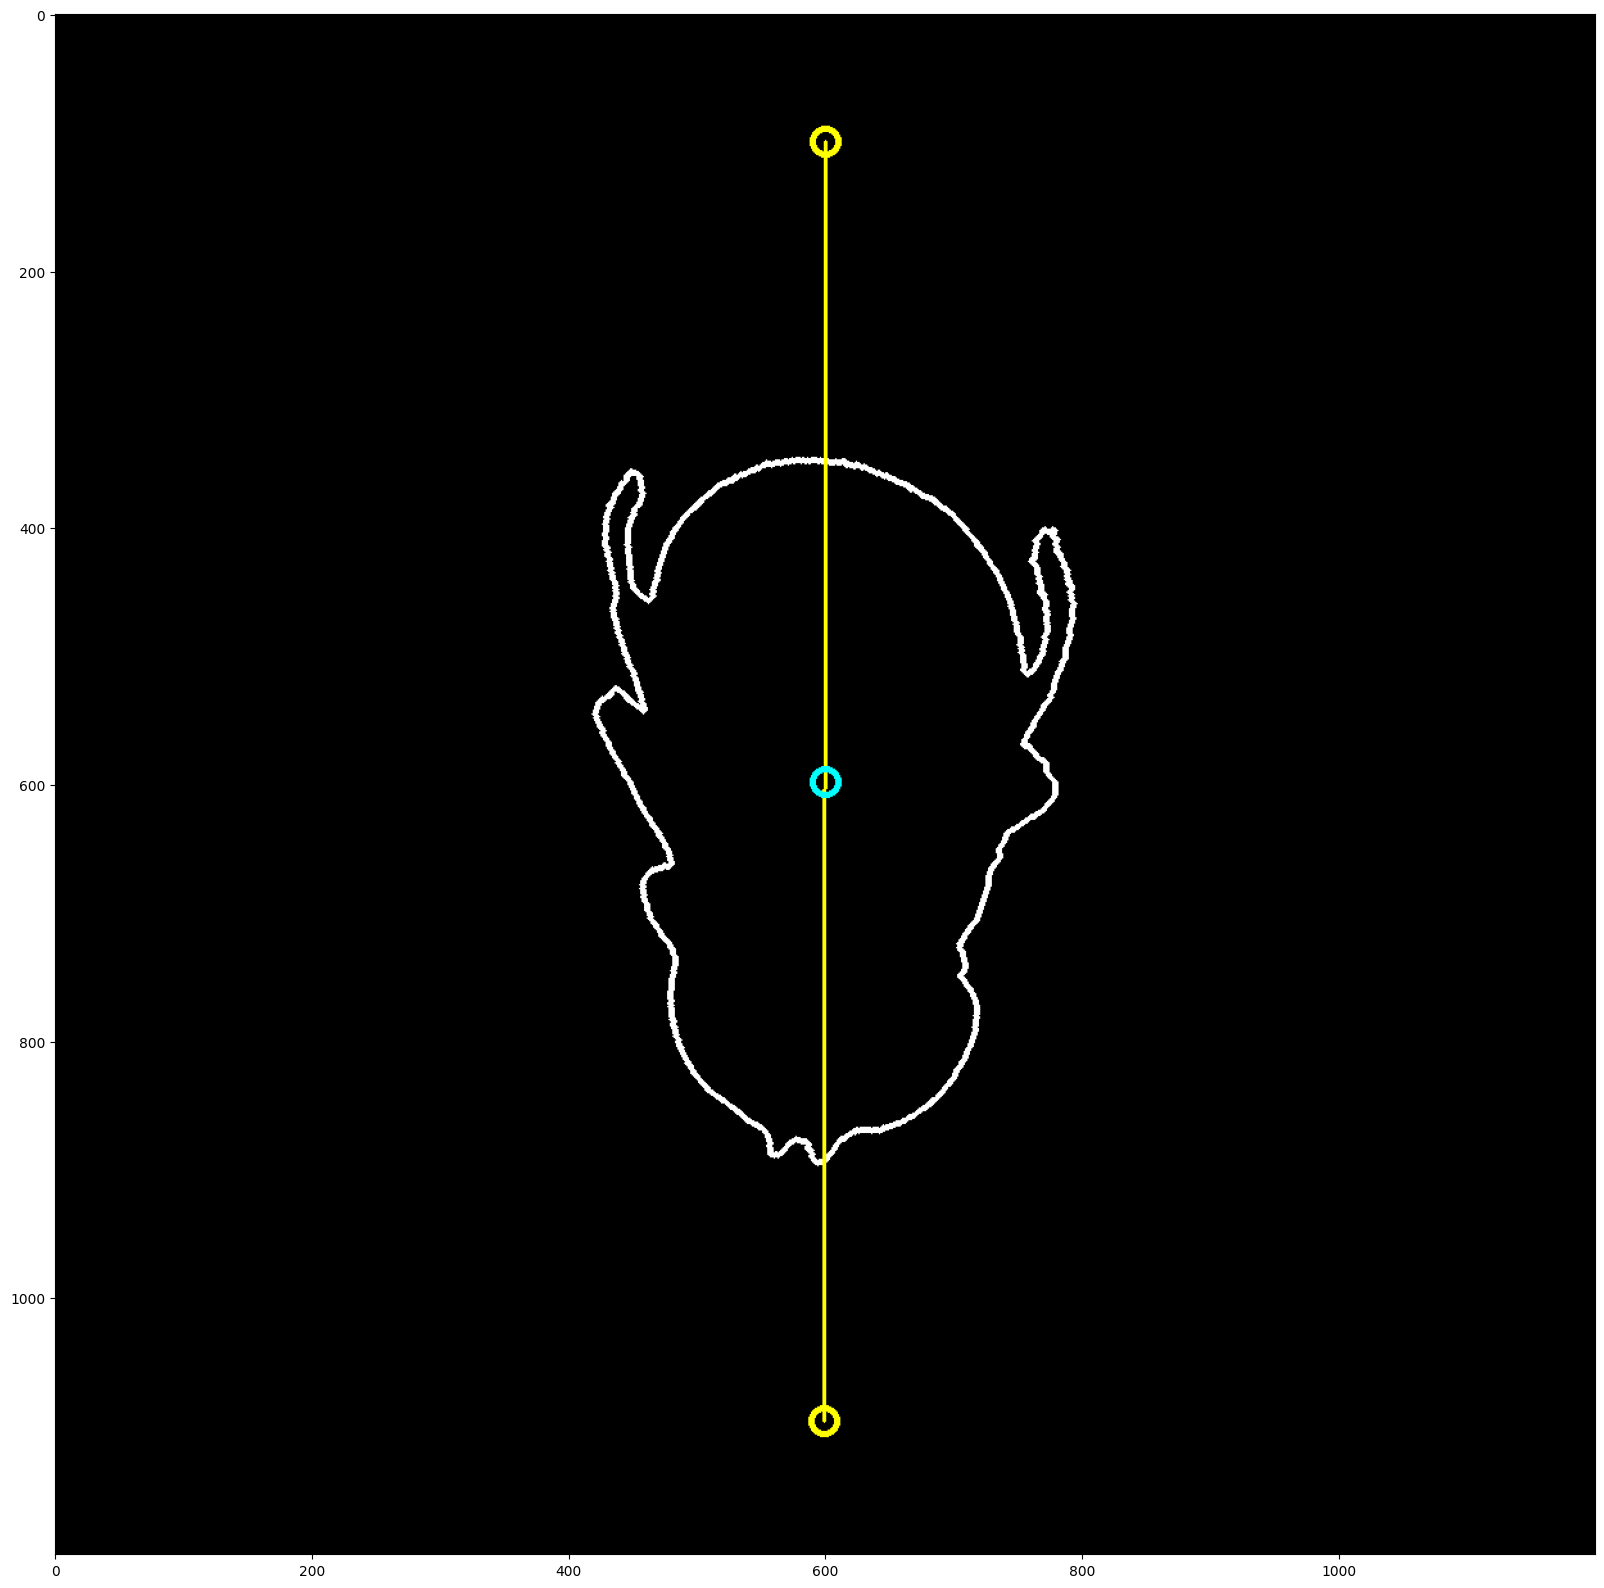

In [7]:
plt.figure(figsize=(20,20))
mask_fly = get_objectmask(fly_mask_hrz,max_contour_hrz)

cv2.circle(mask_fly,body_axis_pt_0_hrz,10, color = (255,255,0),thickness =3)
cv2.circle(mask_fly,body_axis_pt_1_hrz,10, color = (255,255,0),thickness =3)
cv2.line(mask_fly,body_axis_pt_0_hrz,body_axis_pt_1_hrz,color = (255,255,0), thickness = 2)
cv2.circle(mask_fly,centroid_hrz,10,color = (0,255,255),thickness=3)
plt.imshow(mask_fly)

## Labeling
After verifying that your dependancies are working, proceed to label 20 random images of flies from the path provided initially. The labeling process is to assign each image an indication of whether or not the Non Rotated or Rotated image best represents a Fly.

Three Images will be displayed, with the first image represeting the original fly orientation, the second the rotated and transformed fly based on it's orientation (which will allow it to be oriented along the central vertical axis). The last image is a subsequent 180 degree rotation of the fly after the initial rotation and transformation....

Essentially the labeling is a selection between the last two images. After making this selection that image will be saved in order to generate an average mask.

The Criteria for Labeling:
- Fly head facing up in an image then use the respective 'n' or 'r' to assign that image to the fly. with `n` corresponding to `No Rotation` and `r` corresponding to `Rotation`

In [8]:
imgs = {}
import time
import glob
import random
def img_label(filename):
    """
    For each image we will need to ensure that the proper rotation is performed such that it is in the 
    top down rotation
    
    """
    fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(filename)
# mask_fly_norot = get_objectmask(fly_mask_hrz,max_contour_hrz)
    mask_fly_rot = cv2.rotate(copy.deepcopy(fly_mask_hrz),cv2.ROTATE_180)
    dict_img ={
        "n": fly_mask_hrz,
        "r":mask_fly_rot
    }
#     for i in range(1):
    ## test various rotations (0 or 180)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(fly_mask_orig,cmap='gray')
    print(f"<< Original Angle: {polarplt.deg360to180(np.rad2deg(angle_og))} >>")
    plt.subplot(1,3,2)
    plt.title("No Rotation")
    # print("No Rotation Angle:",np.rad2deg(angle))
    print(f"<< No Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og))} >>")
    plt.imshow(fly_mask_hrz,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Rotation")
    print(f"<< Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og)-180)} >>")
    plt.imshow(mask_fly_rot,cmap='gray')
    plt.show()
    
    fly_up = input("Input the name of No Rotation or Rotation depending on which one display fly pointed up. ")
    mask_fly = dict_img[fly_up]
    
    return mask_fly

['/media/loganrower/D5E2-7968/20240502125110/20240502125110_1114.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_5840.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_0364.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_5940.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_5513.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_1831.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_2515.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7768.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_1971.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_5241.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_7054.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_3426.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_6406.png', '/media/loganrower/D5E2-7968/20240502125110/20240502125110_0681.png', '/media/loganrower/

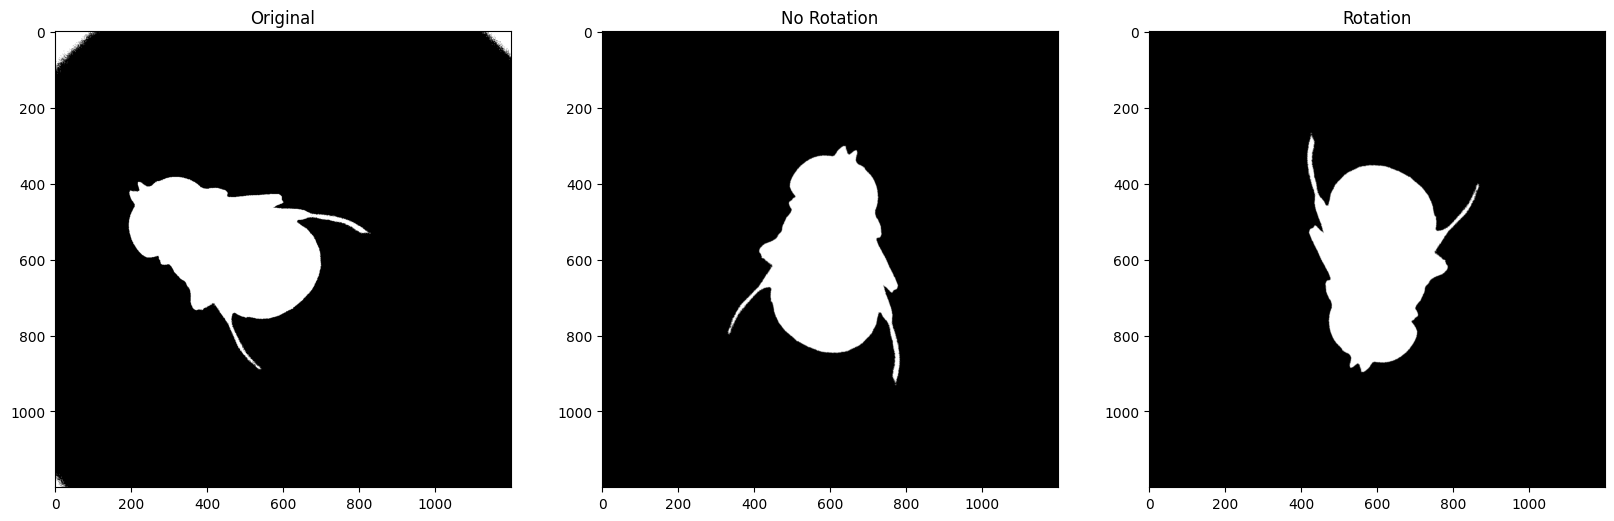

Angle: 65.83584238993022 65.83584238993022
Est Rotated Angle: -114.16415761006976 -1.9925404380614582
Angle: 89.75199041208246 89.75199041208248
Est Rotated Angle: -90.24800958791752 -1.5751249106805716
<< Original Angle: 65.83584238993022 >>
<< No Rotation Angle: 65.83584238993022 >>
<< Rotation Angle: -114.16415761006976 >>


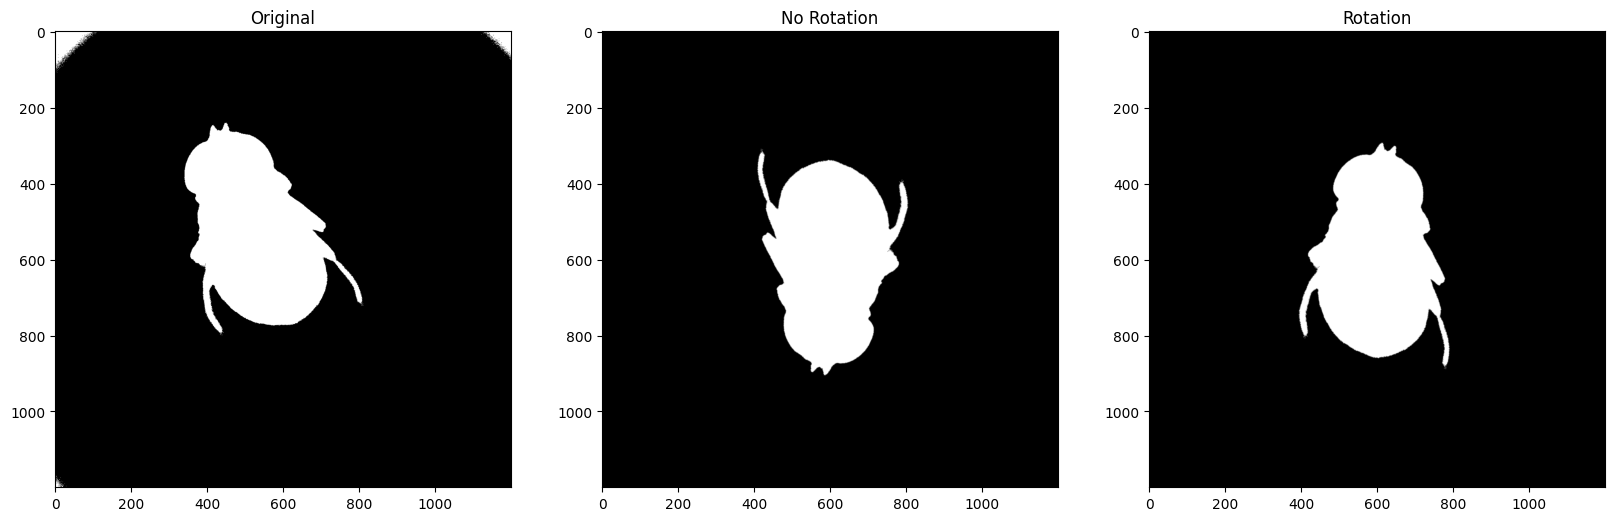

Angle: 178.4351468810583 178.4351468810583
Est Rotated Angle: -1.5648531189416985 -0.02731183923563485
Angle: 89.84205218076075 89.84205218076073
Est Rotated Angle: -90.15794781923927 -1.5735530362869667
<< Original Angle: 178.4351468810583 >>
<< No Rotation Angle: 178.4351468810583 >>
<< Rotation Angle: -1.5648531189416985 >>


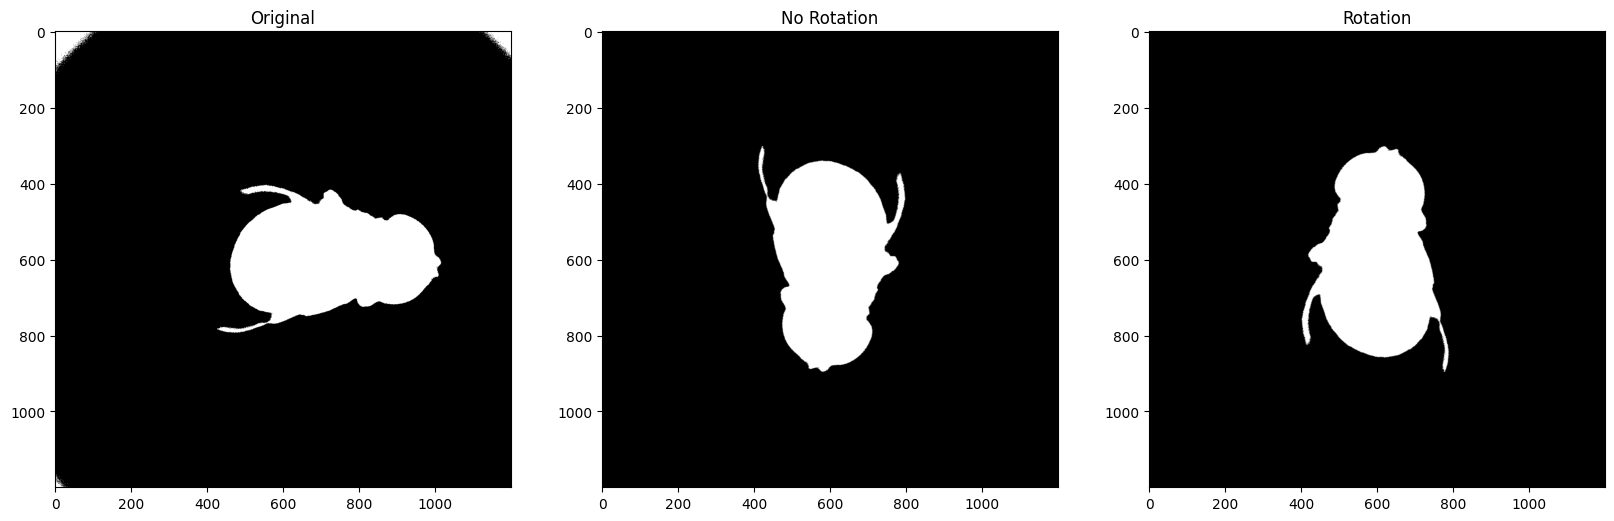

Angle: 134.82446477159374 134.8244647715937
Est Rotated Angle: -45.17553522840626 -0.7884618310863782
Angle: 89.75571425033147 89.75571425033145
Est Rotated Angle: -90.2442857496685 -1.5750599174423154
<< Original Angle: 134.82446477159374 >>
<< No Rotation Angle: 134.82446477159374 >>
<< Rotation Angle: -45.17553522840626 >>


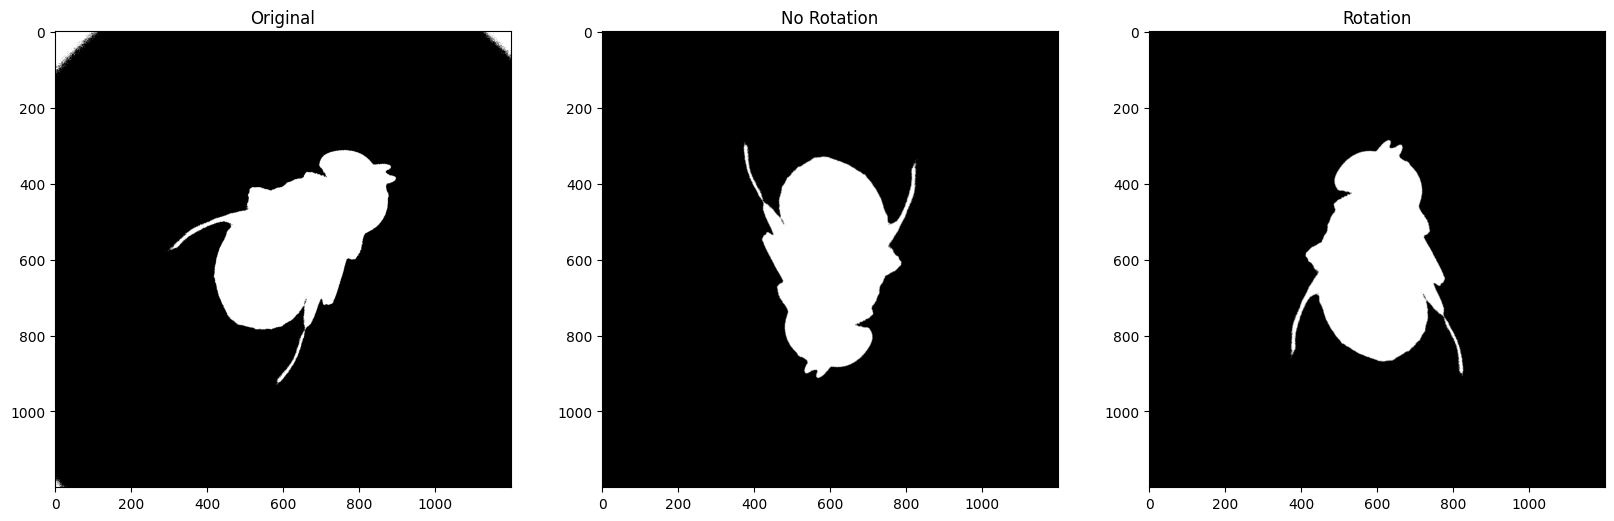

Angle: 133.040725462801 133.040725462801
Est Rotated Angle: -46.95927453719901 -0.819593955022059
Angle: 90.49406621523934 90.49406621523934
Est Rotated Angle: -89.50593378476066 -1.562173244616103
<< Original Angle: 133.040725462801 >>
<< No Rotation Angle: 133.040725462801 >>
<< Rotation Angle: -46.95927453719901 >>


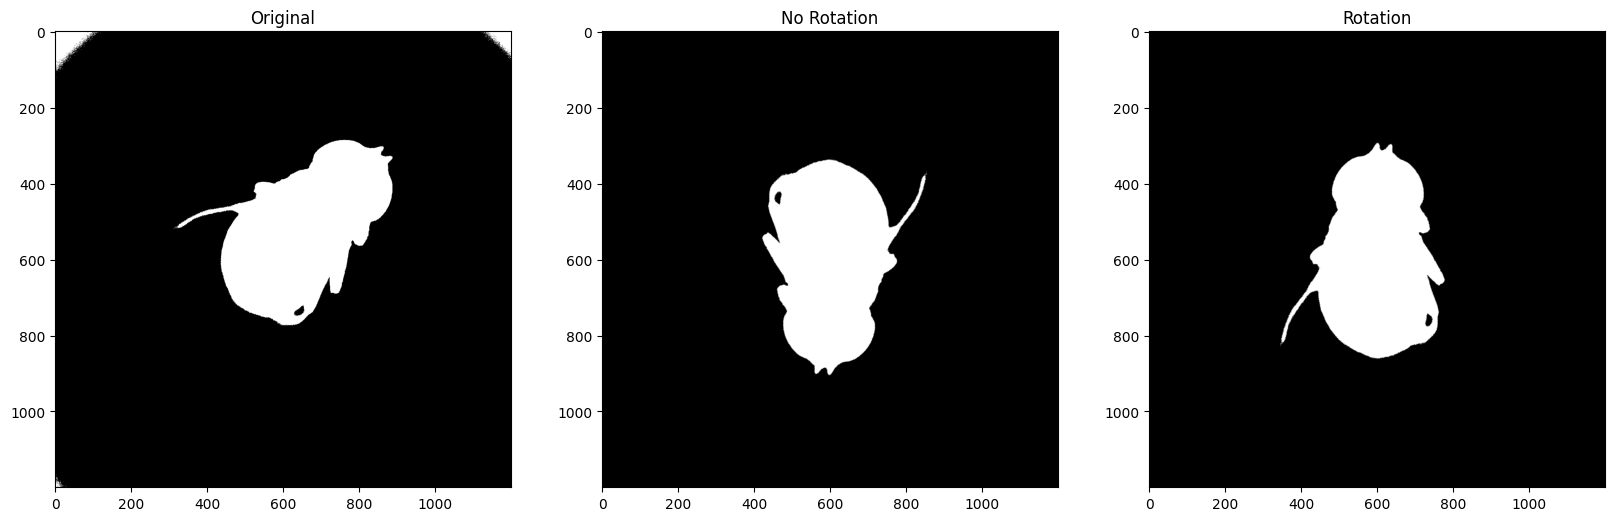

Angle: 117.32824238281714 117.32824238281717
Est Rotated Angle: -62.671757617182834 -1.0938285184316765
Angle: 89.86158889631949 89.86158889631947
Est Rotated Angle: -90.13841110368048 -1.573212056275441
<< Original Angle: 117.32824238281714 >>
<< No Rotation Angle: 117.32824238281714 >>
<< Rotation Angle: -62.671757617182834 >>


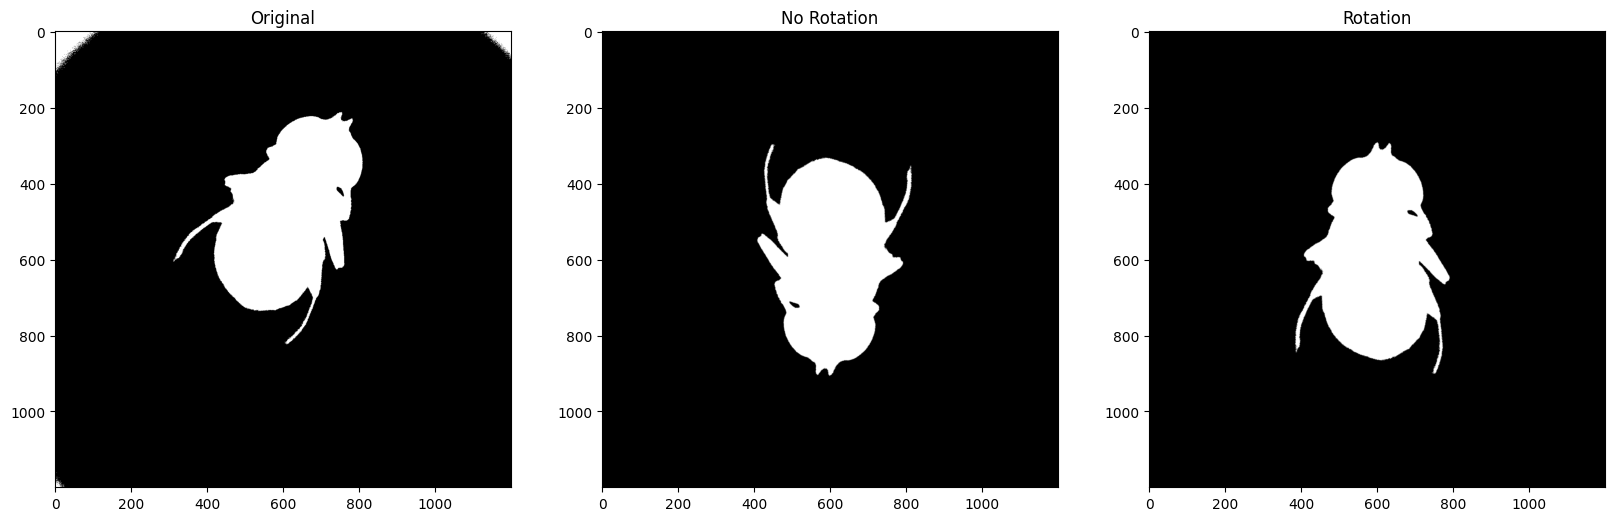

Angle: 99.71331576726098 99.713315767261
Est Rotated Angle: -80.28668423273905 -1.401266985370313
Angle: 89.98986772034486 89.98986772034486
Est Rotated Angle: -90.01013227965512 -1.5709731684356116
<< Original Angle: 99.71331576726098 >>
<< No Rotation Angle: 99.71331576726098 >>
<< Rotation Angle: -80.28668423273905 >>


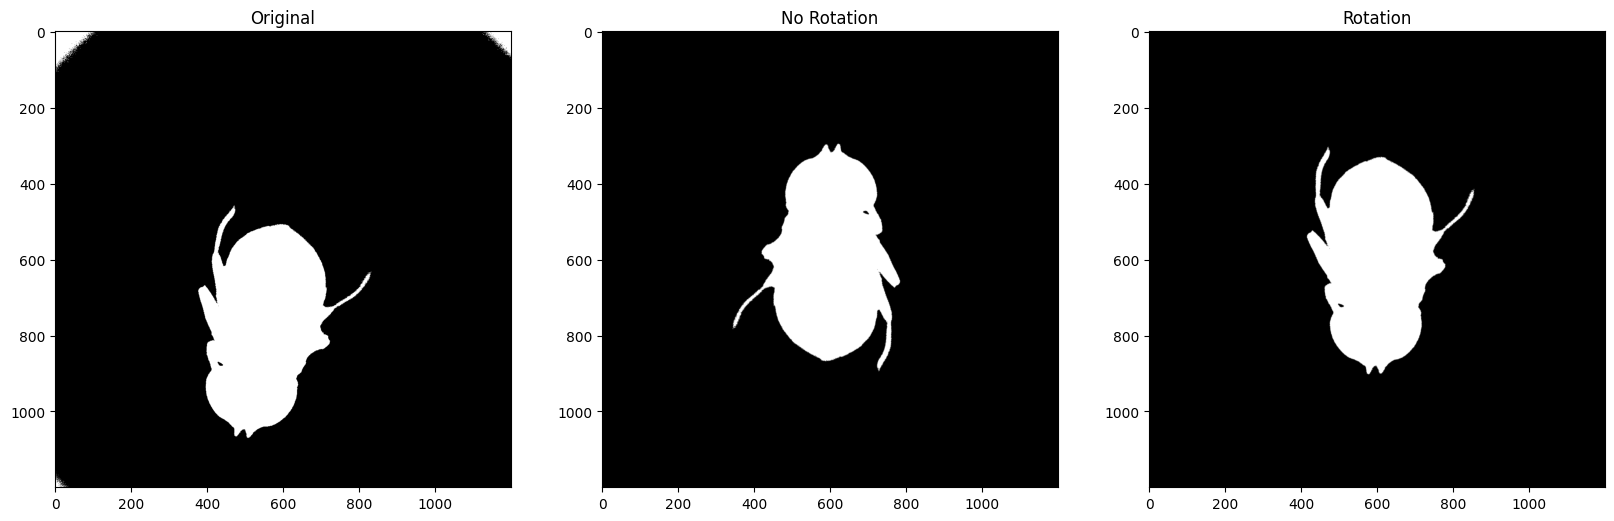

Angle: 155.9383372528379 155.9383372528379
Est Rotated Angle: -24.06166274716213 -0.41995523844244254
Angle: 89.61587985874411 89.61587985874411
Est Rotated Angle: -90.38412014125589 -1.5775004879830377
<< Original Angle: 155.9383372528379 >>
<< No Rotation Angle: 155.9383372528379 >>
<< Rotation Angle: -24.06166274716213 >>


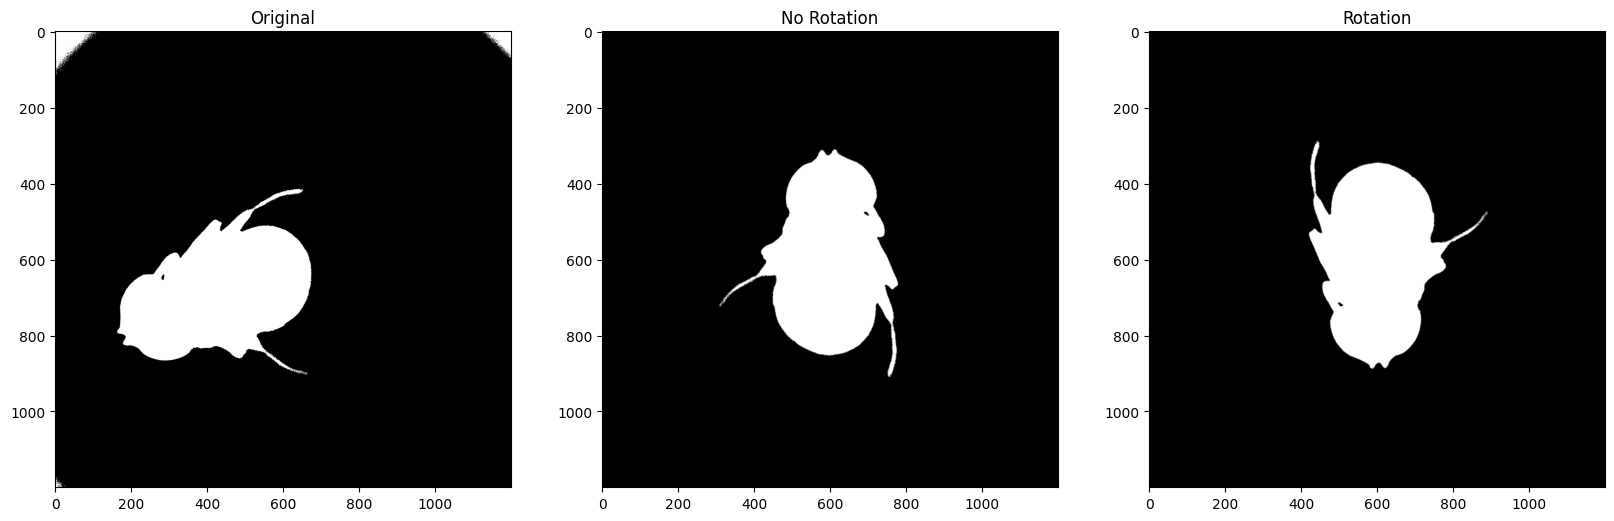

Angle: 103.91445103575865 103.91445103575866
Est Rotated Angle: -76.08554896424135 -1.3279433426133735
Angle: 89.86578980796233 89.86578980796233
Est Rotated Angle: -90.1342101920377 -1.5731387365356877
<< Original Angle: 103.91445103575865 >>
<< No Rotation Angle: 103.91445103575865 >>
<< Rotation Angle: -76.08554896424135 >>


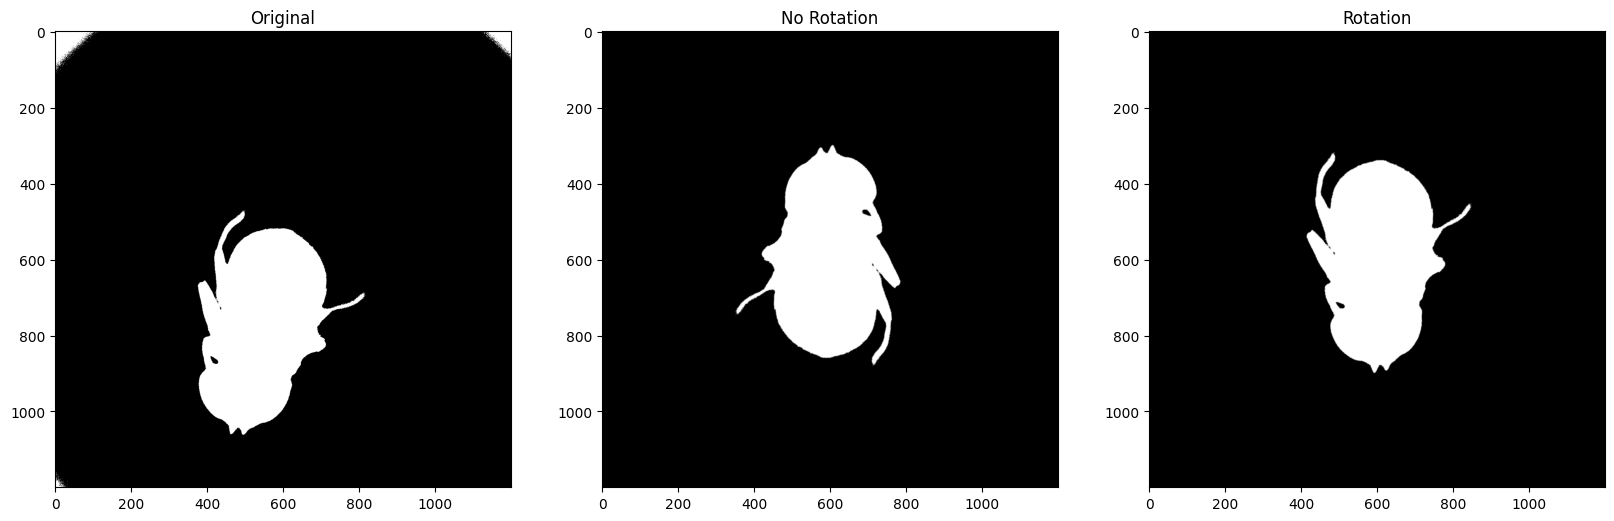

Angle: 124.06422175500686 124.06422175500688
Est Rotated Angle: -55.93577824499312 -0.9762635000405453
Angle: 90.19968253843334 90.19968253843335
Est Rotated Angle: -89.80031746156669 -1.5673112090404944
<< Original Angle: 124.06422175500686 >>
<< No Rotation Angle: 124.06422175500686 >>
<< Rotation Angle: -55.93577824499312 >>


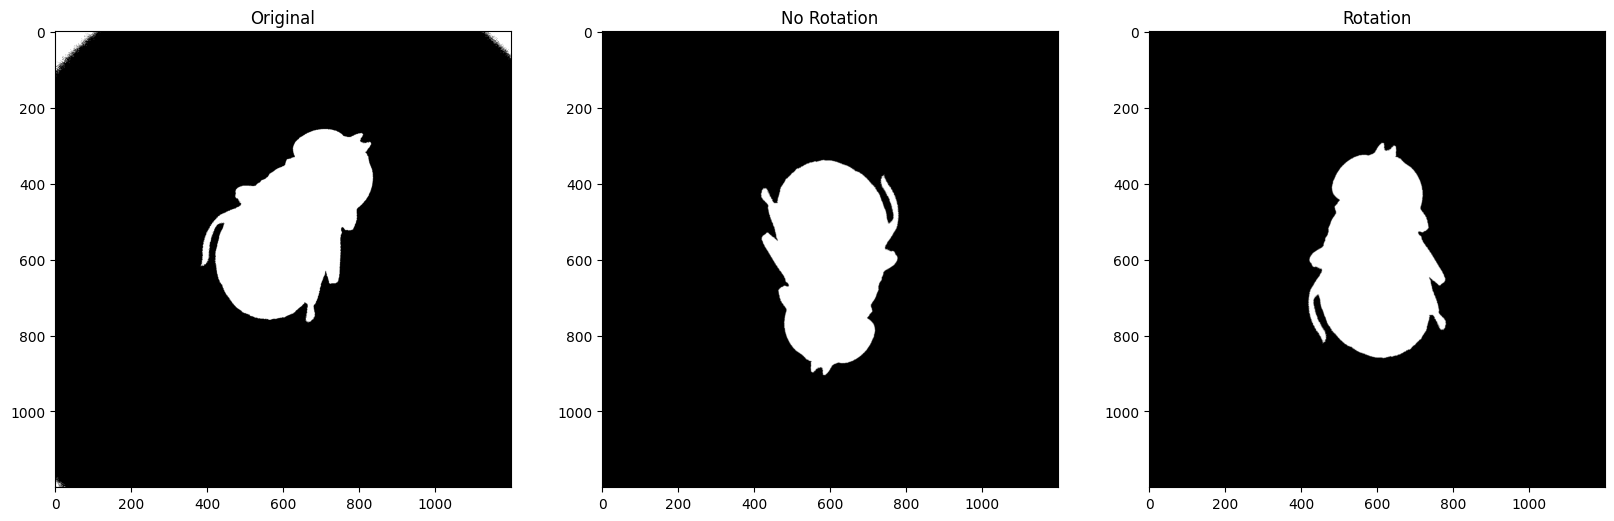

Angle: 59.668385092543176 59.668385092543154
Est Rotated Angle: -120.33161490745681 -2.1001828743770137
Angle: 90.09483996125239 90.09483996125239
Est Rotated Angle: -89.90516003874762 -1.5691410572085784
<< Original Angle: 59.668385092543176 >>
<< No Rotation Angle: 59.668385092543176 >>
<< Rotation Angle: -120.33161490745681 >>


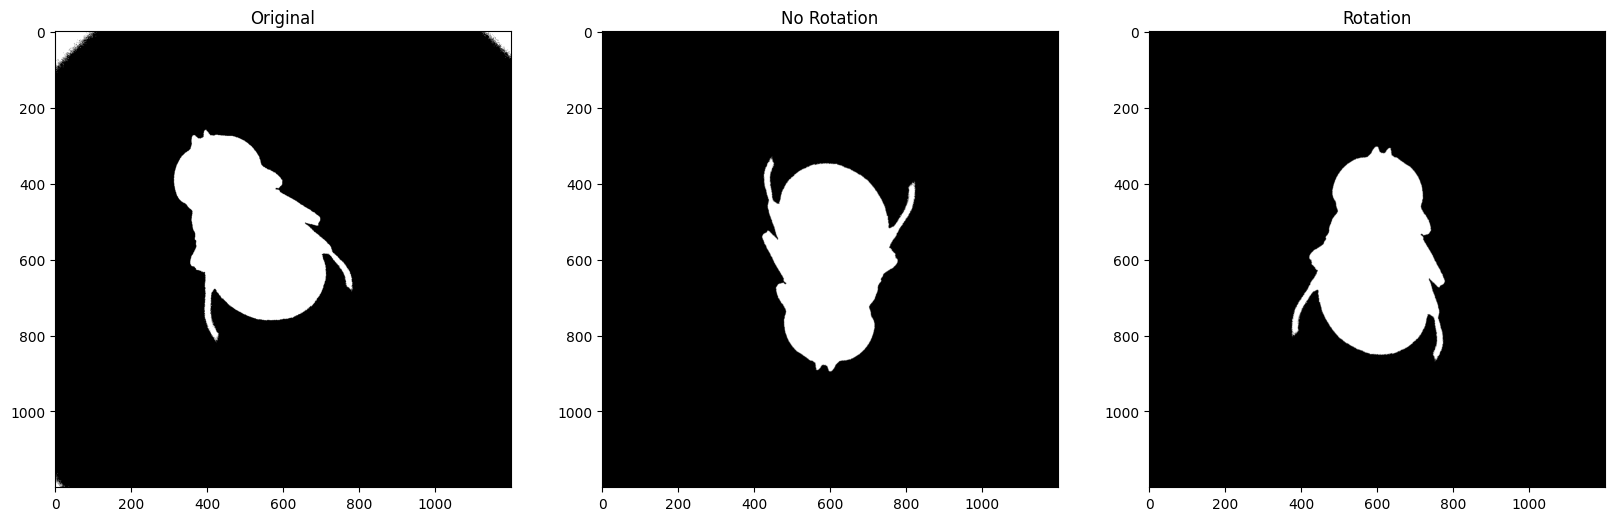

Angle: 84.06989207415444 84.06989207415445
Est Rotated Angle: -95.93010792584556 -1.6742962350995132
Angle: 89.9609038014902 89.9609038014902
Est Rotated Angle: -90.03909619850981 -1.571478684183906
<< Original Angle: 84.06989207415444 >>
<< No Rotation Angle: 84.06989207415444 >>
<< Rotation Angle: -95.93010792584556 >>


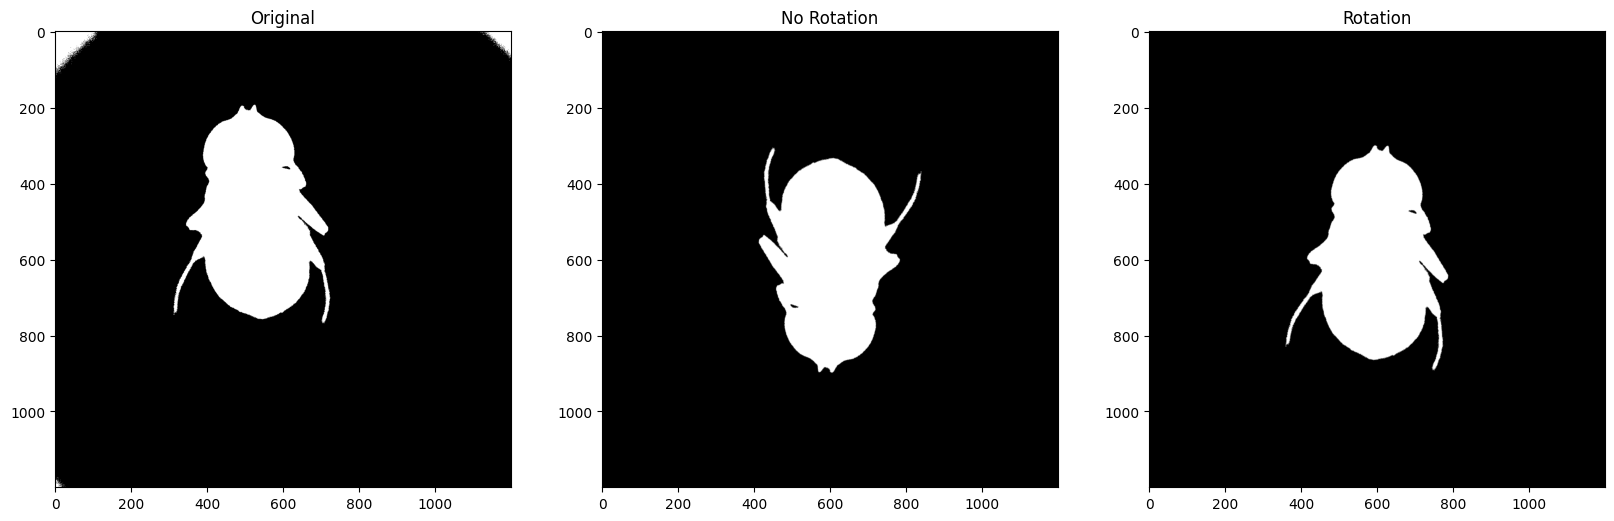

Angle: 105.17419070021093 105.17419070021091
Est Rotated Angle: -74.82580929978906 -1.3059567377507122
Angle: 89.73290792241804 89.73290792241804
Est Rotated Angle: -90.26709207758199 -1.5754579629546939
<< Original Angle: 105.17419070021093 >>
<< No Rotation Angle: 105.17419070021093 >>
<< Rotation Angle: -74.82580929978906 >>


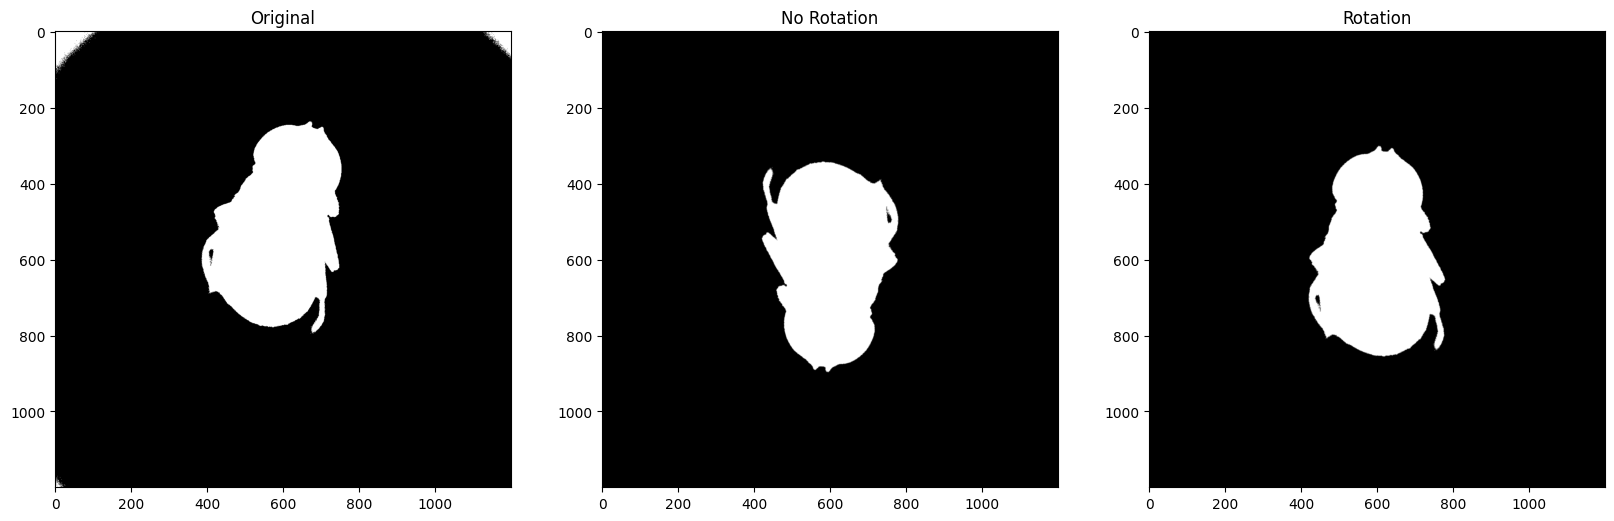

Angle: 49.51392811440789 49.513928114407896
Est Rotated Angle: -130.4860718855921 -2.277411582397588
Angle: 89.73944667360132 89.7394466736013
Est Rotated Angle: -90.26055332639868 -1.5753438402175775
<< Original Angle: 49.51392811440789 >>
<< No Rotation Angle: 49.51392811440789 >>
<< Rotation Angle: -130.4860718855921 >>


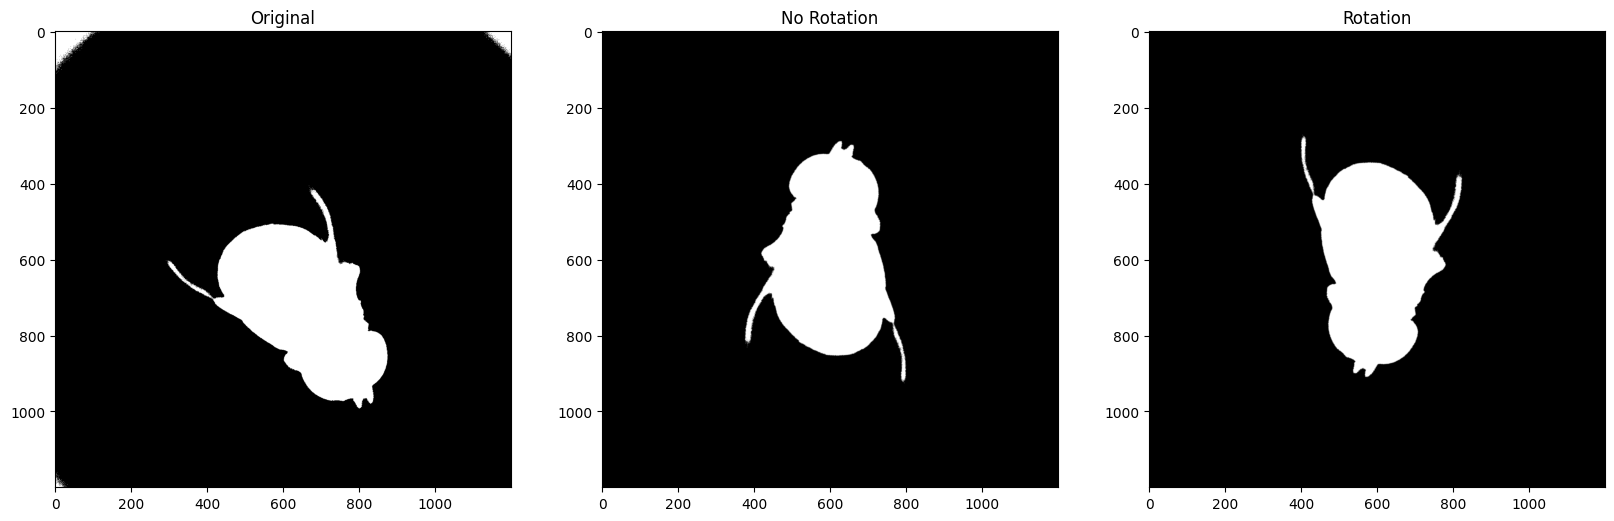

Angle: 62.12538568246592 62.12538568246592
Est Rotated Angle: -117.87461431753408 -2.0573001243594184
Angle: 89.88634242512586 89.88634242512586
Est Rotated Angle: -90.11365757487414 -1.5727800256962823
<< Original Angle: 62.12538568246592 >>
<< No Rotation Angle: 62.12538568246592 >>
<< Rotation Angle: -117.87461431753408 >>


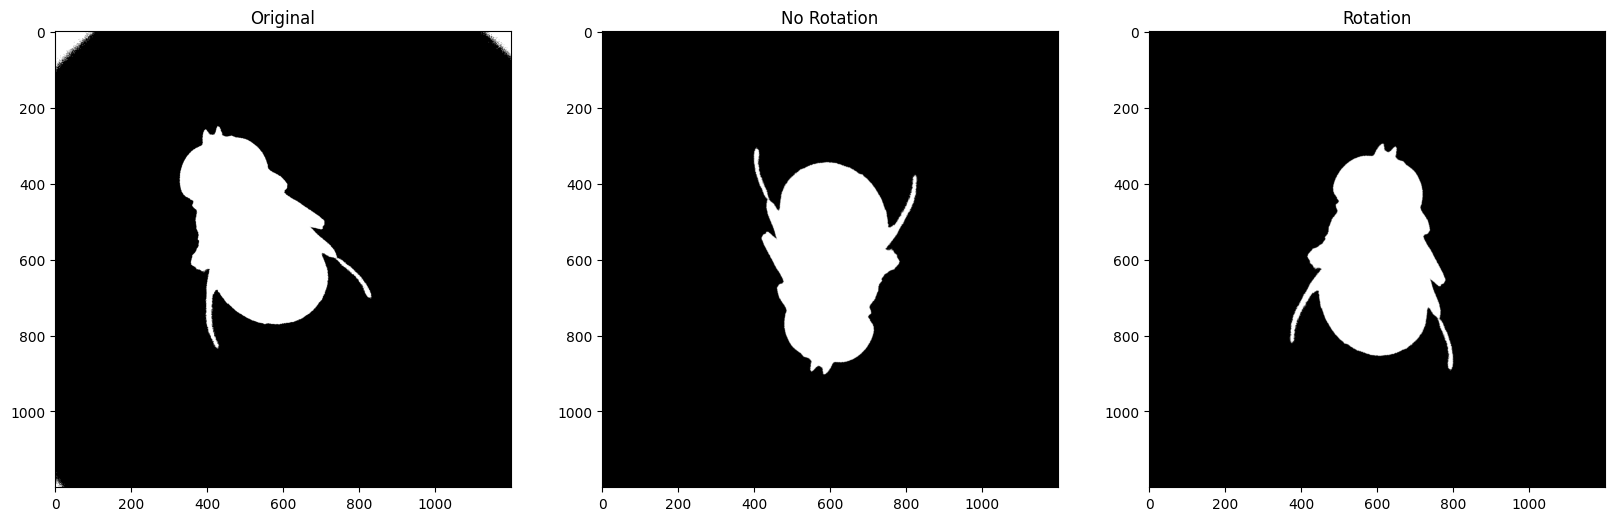

Angle: 121.91512192859658 121.91512192859655
Est Rotated Angle: -58.08487807140341 -1.0137723679654442
Angle: 89.56607951746788 89.56607951746787
Est Rotated Angle: -90.43392048253213 -1.5783696679069248
<< Original Angle: 121.91512192859658 >>
<< No Rotation Angle: 121.91512192859658 >>
<< Rotation Angle: -58.08487807140341 >>


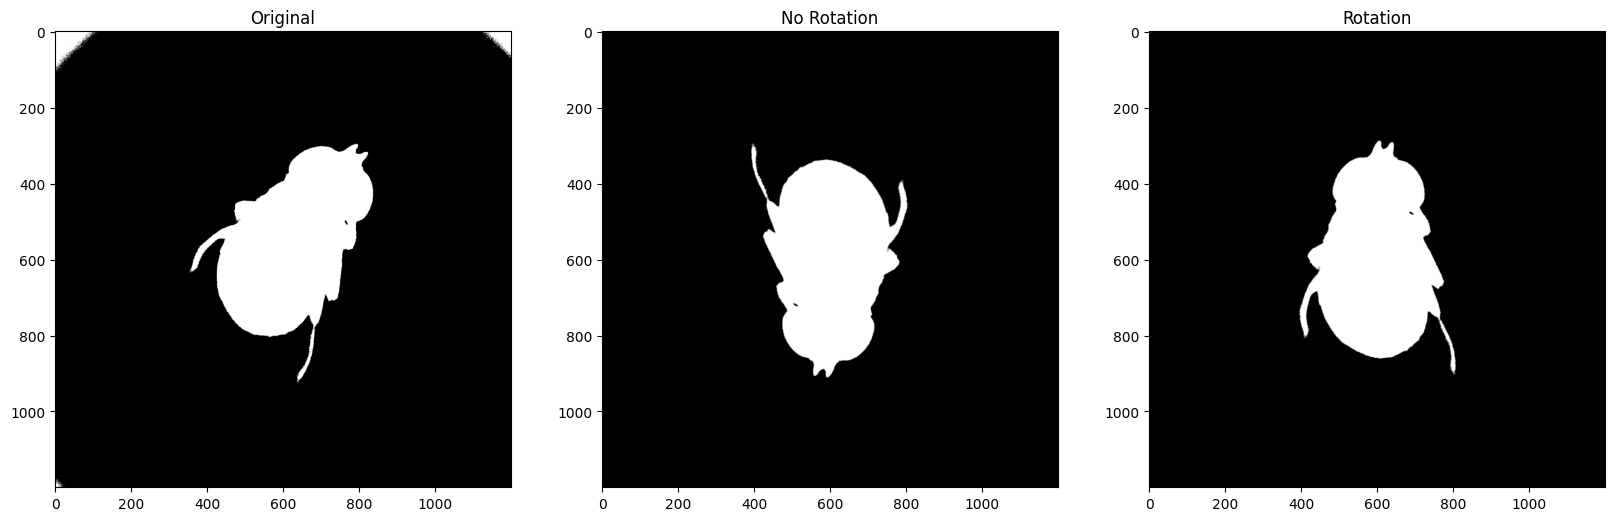

Angle: 148.3841762940289 148.3841762940289
Est Rotated Angle: -31.61582370597114 -0.5518002193992722
Angle: 90.21828855318425 90.21828855318424
Est Rotated Angle: -89.78171144681573 -1.5669864728224168
<< Original Angle: 148.3841762940289 >>
<< No Rotation Angle: 148.3841762940289 >>
<< Rotation Angle: -31.61582370597114 >>


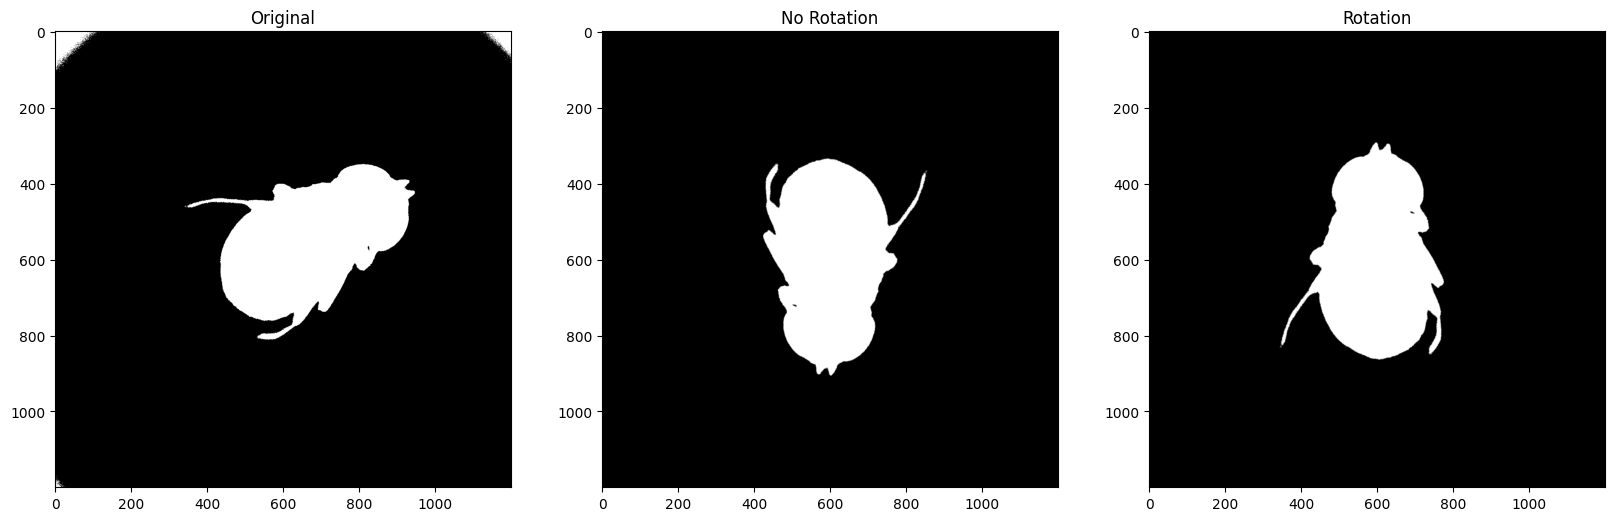

Angle: 69.25752222016246 69.25752222016246
Est Rotated Angle: -110.74247777983754 -1.932820859074825
Angle: 90.07456808320042 90.0745680832004
Est Rotated Angle: -89.9254319167996 -1.5694948682261485
<< Original Angle: 69.25752222016246 >>
<< No Rotation Angle: 69.25752222016246 >>
<< Rotation Angle: -110.74247777983754 >>


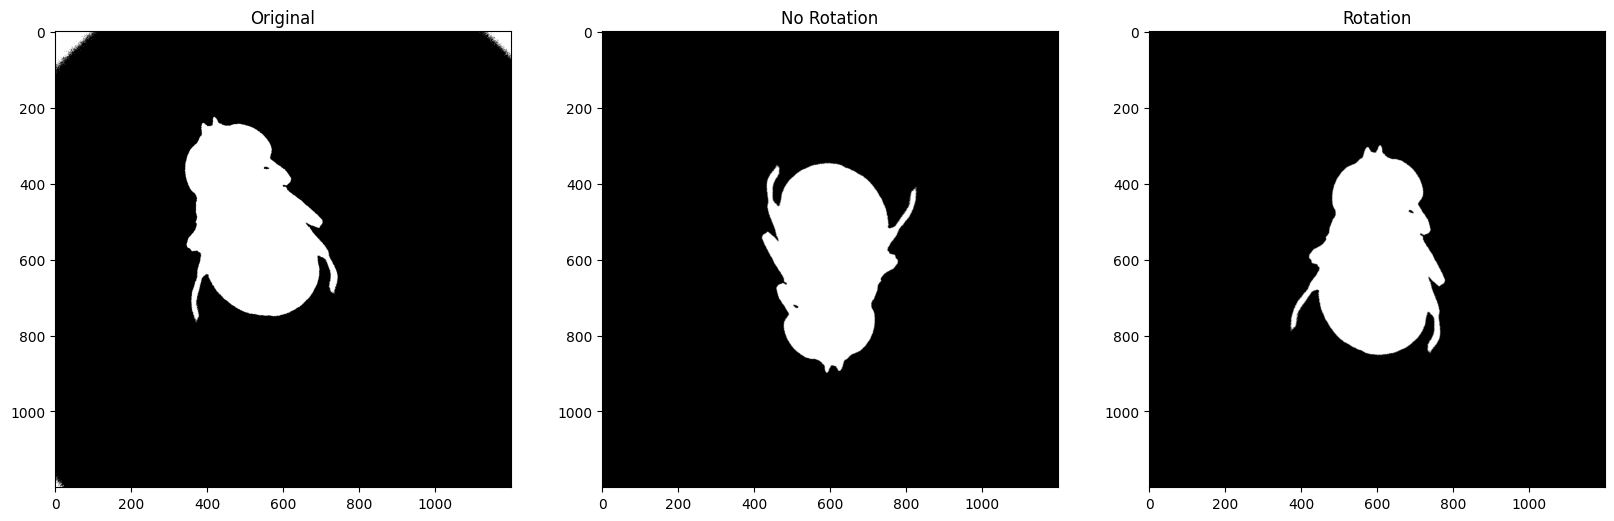

Angle: 78.01243907136491 78.01243907136491
Est Rotated Angle: -101.9875609286351 -1.7800187342830078
Angle: 89.80750270389326 89.80750270389325
Est Rotated Angle: -90.19249729610675 -1.5741560384131459
<< Original Angle: 78.01243907136491 >>
<< No Rotation Angle: 78.01243907136491 >>
<< Rotation Angle: -101.9875609286351 >>


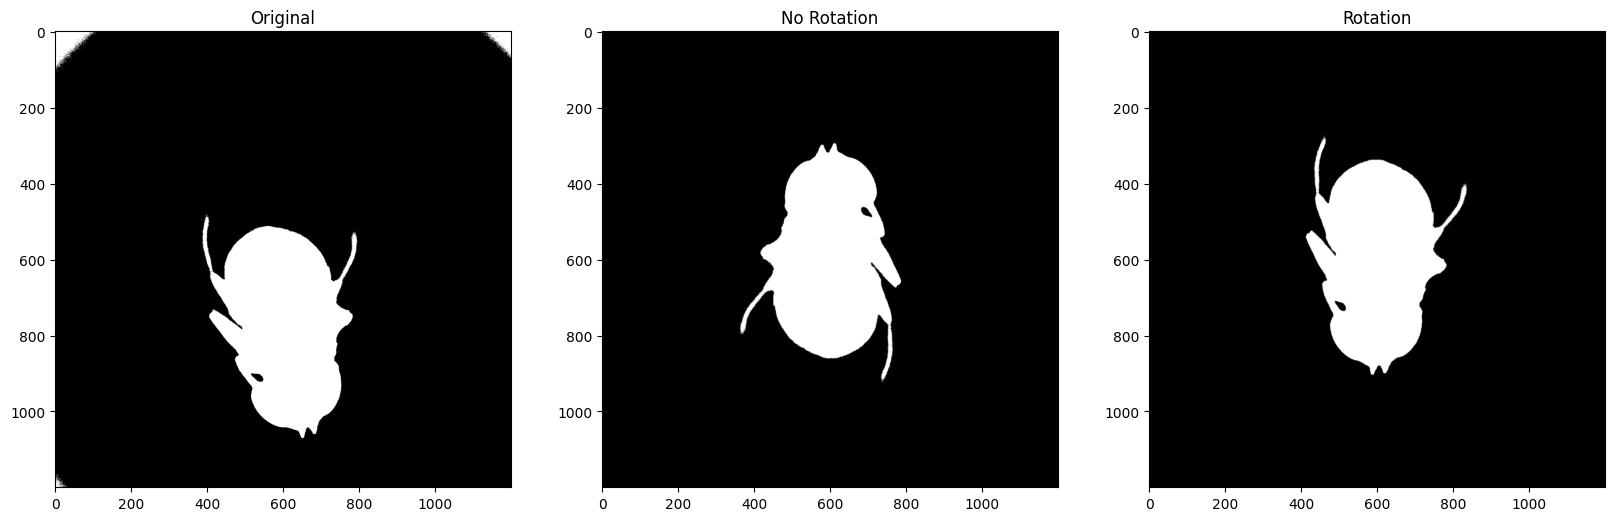

Angle: -147.3177413501449 -147.3177413501449
Est Rotated Angle: 32.6822586498551 0.5704130204283682
Angle: 89.87162583493455 89.87162583493453
Est Rotated Angle: -90.12837416506545 -1.5730368786497877
<< Original Angle: -147.3177413501449 >>
<< No Rotation Angle: -147.3177413501449 >>
<< Rotation Angle: 32.6822586498551 >>


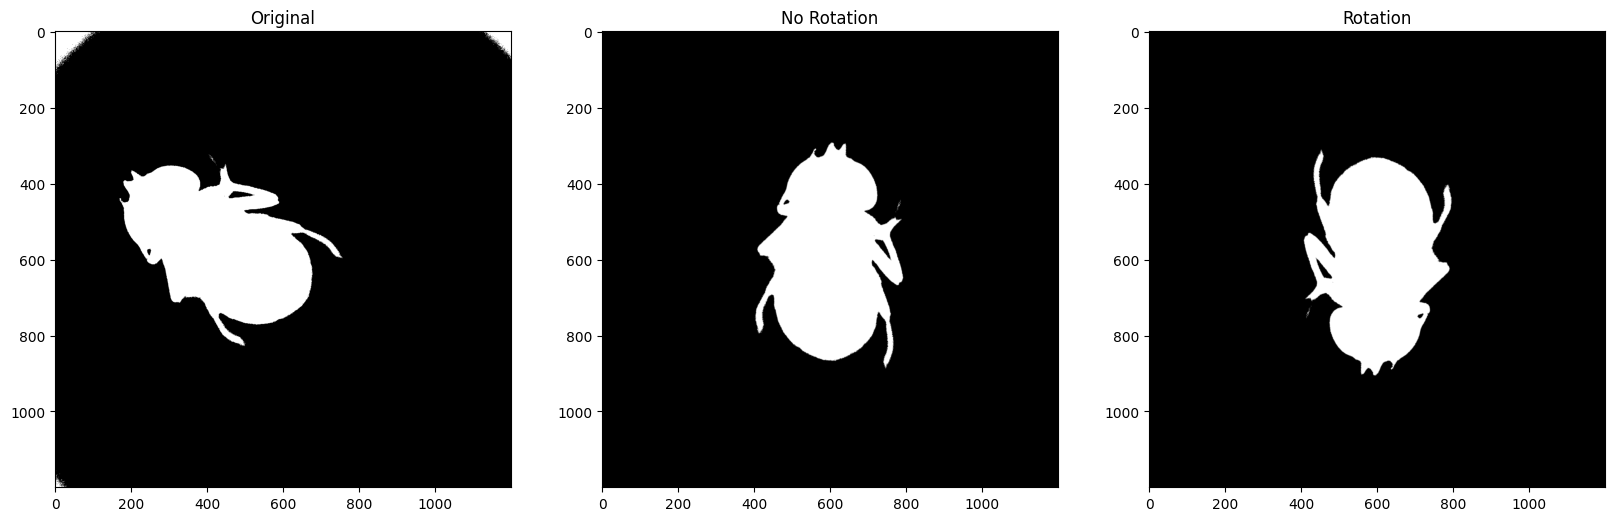

In [9]:
# get all of the files in the folder
shuffled_list = sorted(img_data , key=lambda x: random.random())
print(shuffled_list)
for file in shuffled_list[:20]:
    name = file.split('/')[-1].strip('.png')
    mask_fly = img_label(file)
    imgs[name] = mask_fly
    # execute function and then add these images and etc to the dictionary

## Average Fly Mask Template 
Using the 20 labelled images, a grayscale template mask will be developed of the fly facing upward. This average mask will then be tested against all images in the dataset to determine correct orientation.

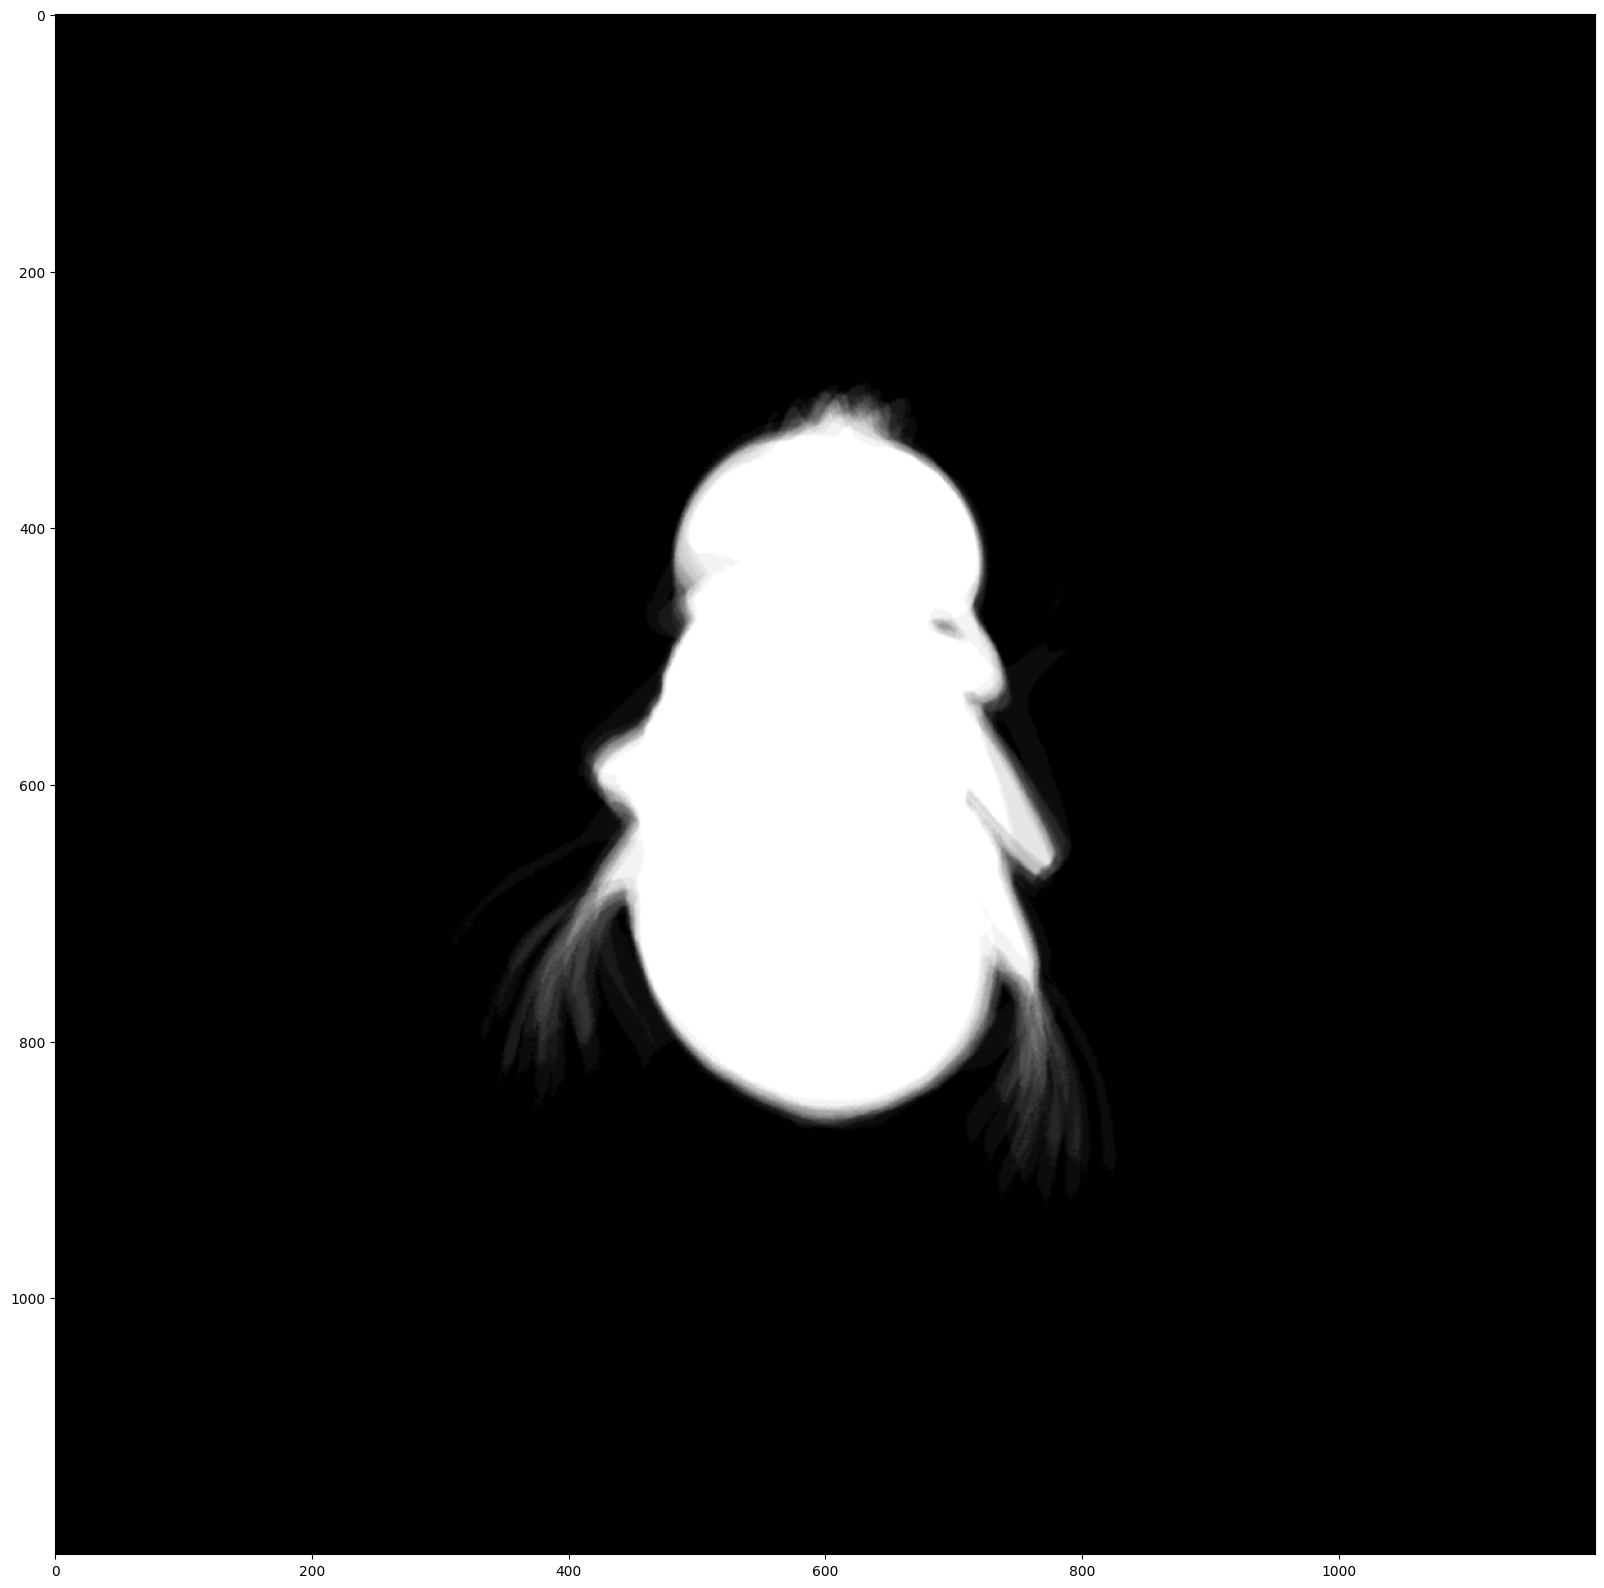

In [10]:
### Now with all the images we will create a mean tempate mask
final = []
for img in imgs.keys():
    final.append(imgs[img])
# print(final)
stacked = np.stack(final,axis=-1)
avg_mask = np.mean(stacked, axis = -1)
plt.figure(figsize=(20,20))
plt.imshow(avg_mask,cmap = 'gray')

## MSE Comparison
The entire image dataset will be tested against this average mask to determine the correct orientation of the fly. The MSE Rot and MSE No Rot will be logged as well as whether fly is No Rot or Rot.

In [11]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
def data_mse(data):
    data_results = {
        "file":[],
        "type":[],
        "MSE":[],
        "Original Angle":[],
        "Adjusted Angle":[]
    }
    for file in data:
        name = file.split('/')[-1].strip('.png')
        mask_fly= contour_hrz_matrix(file)[1].astype(float)
        angle_og = contour_hrz_matrix(file)[6]
        ## No Rotation or Rotation
        d = {
            "MSE No Rotation":mse(avg_mask,mask_fly),
            "MSE Rotation": mse(avg_mask,cv2.rotate(mask_fly,cv2.ROTATE_180))
        }
        # print(d)
        
        ## Save the min MSE Value
        data_results["file"].append(name)
        img_rot_type = list(d.keys())[list(d.values()).index(min(list(d.values())))]
        if img_rot_type == "MSE No Rotation":
            angle_og_deg= polarplt.deg360to180(np.rad2deg(angle_og))
            angle_adj = polarplt.deg360to180(np.rad2deg(angle_og))
        else:
            angle_og_deg = polarplt.deg360to180(np.rad2deg(angle_og))
            angle_adj = polarplt.deg360to180(np.rad2deg(angle_og)-180)

        data_results['type'].append(img_rot_type)
        data_results["MSE"].append((d["MSE No Rotation"],d["MSE Rotation"])) # both MSE values...
        data_results['Original Angle'].append(angle_og_deg)
        data_results['Adjusted Angle'].append(angle_adj)
        print("----------------")
    return data_results


In [12]:
imgs[list(imgs.keys())[0]].dtype
img1 = imgs[list(imgs.keys())[18]].astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 269.0281883524305
Rotation: 1214.8575470329854


In [52]:
np.random.choice(img_data)

'/media/loganrower/D5E2-7968/20240502125110/20240502125110_7775.png'

In [20]:
img_path = ('/media/loganrower/D5E2-7968/20240502125110/20240502125110_7355.png')
fly_mask_orig1, fly_mask_hrz1,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(img_path)
img1 = fly_mask_hrz1.astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("------------")
print(angle_og)
print(np.rad2deg(angle_og))
print(polarplt.deg360to180(np.rad2deg(angle_og)-180))
print(angle_rot)
print(np.rad2deg(angle_rot))


Angle: 71.60198091314216 71.60198091314216
Est Rotated Angle: -108.39801908685786 -1.8919023357053266
Angle: 90.0536226428922 90.05362264289221
Est Rotated Angle: -89.94637735710779 -1.5698604351228065
------------
1.2496903178844665
71.60198091314216
-108.39801908685786
1.5717322184669864
90.0536226428922


<< Original Angle: 71.60198091314216 >>
<< No Rotation Angle: 71.60198091314216 >>
<< Rotation Angle: -108.39801908685786 >>


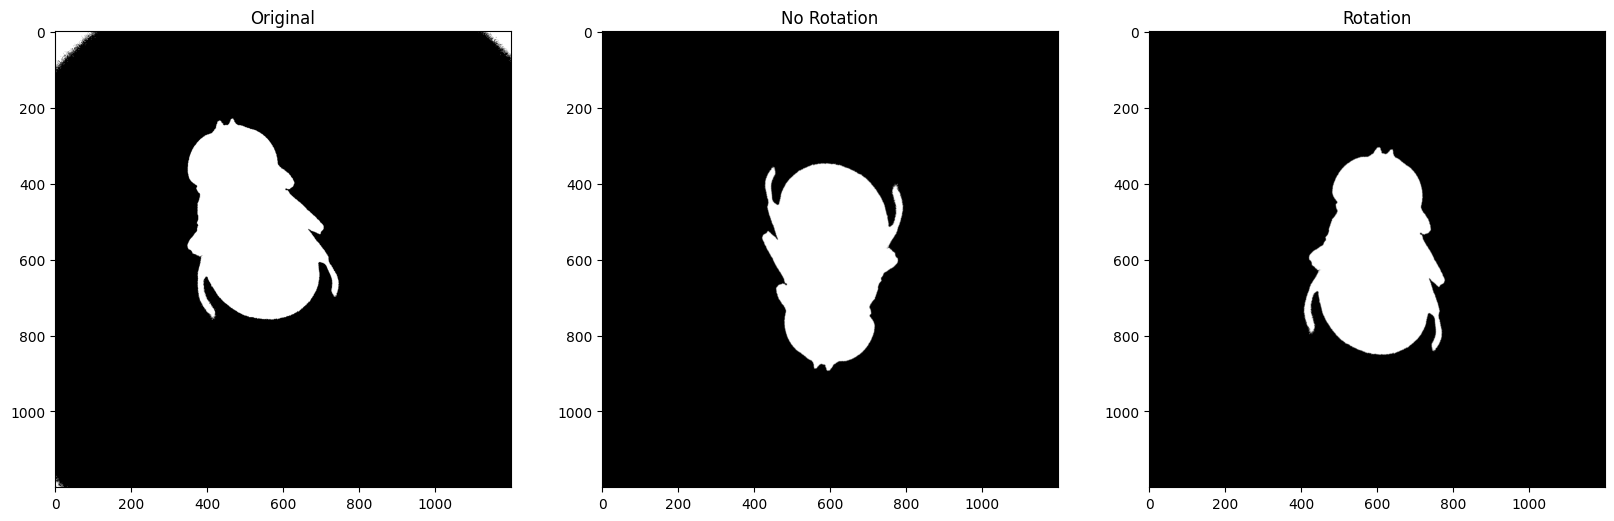

In [22]:
mask_fly_rot1 = cv2.rotate(copy.deepcopy(fly_mask_hrz1),cv2.ROTATE_180)

fig = plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(fly_mask_orig1,cmap='gray')
print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
plt.subplot(1,3,2)
plt.title("No Rotation")
# print("No Rotation Angle:",np.rad2deg(angle))
print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
plt.imshow(fly_mask_hrz1,cmap='gray')
plt.subplot(1,3,3)
plt.title("Rotation")
print(f"<< Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og)-180)} >>")
plt.imshow(mask_fly_rot1,cmap='gray')
plt.show()

In [23]:
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 1326.1465215468743
Rotation: 203.93856738020833


The `data_mse` function can take from 10-15 min based on size of the dataset.

In [24]:
results = data_mse(img_data)
results

Angle: -151.56315612336587 -151.56315612336587
Est Rotated Angle: 28.43684387663413 0.4963165545228536
Angle: 89.95270842557174 89.95270842557173
Est Rotated Angle: -90.04729157442824 -1.571621720477122
Angle: -151.56315612336587 -151.56315612336587
Est Rotated Angle: 28.43684387663413 0.4963165545228536
Angle: 89.95270842557174 89.95270842557173
Est Rotated Angle: -90.04729157442824 -1.571621720477122
----------------
Angle: 171.74574168845953 171.74574168845953
Est Rotated Angle: -8.254258311540468 -0.14406398484648975
Angle: 89.86981333873817 89.86981333873814
Est Rotated Angle: -90.13018666126186 -1.5730685126760946
Angle: 171.74574168845953 171.74574168845953
Est Rotated Angle: -8.254258311540468 -0.14406398484648975
Angle: 89.86981333873817 89.86981333873814
Est Rotated Angle: -90.13018666126186 -1.5730685126760946
----------------
Angle: 145.2359769345717 145.23597693457174
Est Rotated Angle: -34.76402306542832 -0.6067466637309753
Angle: 89.75972890132275 89.75972890132275
Est R

{'file': ['20240502125110_0008',
  '20240502125110_0011',
  '20240502125110_0024',
  '20240502125110_0026',
  '20240502125110_0027',
  '20240502125110_0029',
  '20240502125110_0031',
  '20240502125110_0041',
  '20240502125110_0046',
  '20240502125110_0052',
  '20240502125110_0062',
  '20240502125110_0104',
  '20240502125110_0105',
  '20240502125110_0138',
  '20240502125110_0192',
  '20240502125110_0203',
  '20240502125110_0209',
  '20240502125110_0212',
  '20240502125110_0215',
  '20240502125110_0230',
  '20240502125110_0235',
  '20240502125110_0240',
  '20240502125110_0258',
  '20240502125110_0259',
  '20240502125110_0265',
  '20240502125110_0292',
  '20240502125110_0296',
  '20240502125110_0306',
  '20240502125110_0307',
  '20240502125110_0311',
  '20240502125110_0330',
  '20240502125110_0351',
  '20240502125110_0370',
  '20240502125110_0376',
  '20240502125110_0407',
  '20240502125110_0410',
  '20240502125110_0415',
  '20240502125110_0422',
  '20240502125110_0423',
  '20240502125110

The dictionary is then transformed into a dataframe for additional processing and subsequent plotting

In [25]:
results_df = pd.DataFrame(results)
results_df.head()

file             type  \
0  20240502125110_0008     MSE Rotation   
1  20240502125110_0011  MSE No Rotation   
2  20240502125110_0024  MSE No Rotation   
3  20240502125110_0026  MSE No Rotation   
4  20240502125110_0027  MSE No Rotation   

                                        MSE  Original Angle  Adjusted Angle  
0  (1084.0032877274302, 423.95036078298637)     -151.563156       28.436844  
1   (370.42690342187507, 1212.345809046874)      171.745742      171.745742  
2  (414.49320883854136, 1346.8829395329853)      145.235977      145.235977  
3   (406.16519182465277, 1361.224032588541)     -175.968158     -175.968158  
4  (421.42234501909695, 1389.6079087690966)     -156.853924     -156.853924

# Plot all data

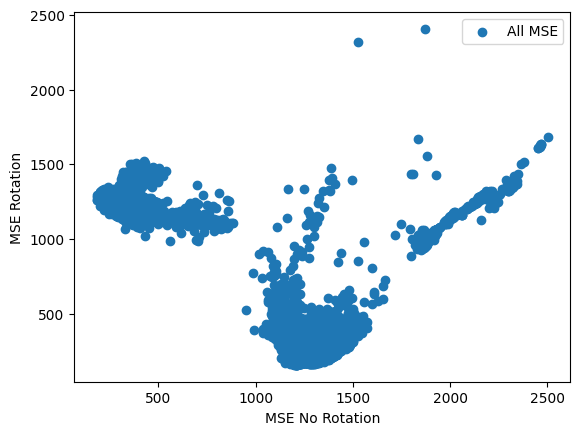

In [26]:
plt.scatter(results_df['MSE'].apply(lambda x: x[0]),results_df['MSE'].apply(lambda x: x[1]),label = 'All MSE')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

## Plot of MSE ERROR No Rotation vs Rotation for Large Dataset

Using the average mask from before we will now look at all the images in the dataset to determine accuracy. 

In [27]:
results_df.head(10)

file             type  \
0  20240502125110_0008     MSE Rotation   
1  20240502125110_0011  MSE No Rotation   
2  20240502125110_0024  MSE No Rotation   
3  20240502125110_0026  MSE No Rotation   
4  20240502125110_0027  MSE No Rotation   
5  20240502125110_0029     MSE Rotation   
6  20240502125110_0031     MSE Rotation   
7  20240502125110_0041  MSE No Rotation   
8  20240502125110_0046     MSE Rotation   
9  20240502125110_0052  MSE No Rotation   

                                        MSE  Original Angle  Adjusted Angle  
0  (1084.0032877274302, 423.95036078298637)     -151.563156       28.436844  
1   (370.42690342187507, 1212.345809046874)      171.745742      171.745742  
2  (414.49320883854136, 1346.8829395329853)      145.235977      145.235977  
3   (406.16519182465277, 1361.224032588541)     -175.968158     -175.968158  
4  (421.42234501909695, 1389.6079087690966)     -156.853924     -156.853924  
5    (1406.88465147743, 398.28867154687487)       61.199825     -118.800175  
6   (1429.3196393940968, 388.2444666857638)      102.842317      -77.157683  
7   (433.58235161631944, 1377.133414116319)      165.103532      165.103532  
8   (1377.6417872413188, 350.0948014774306)       91.277005      -88.722995  
9   (412.0647841163194, 1387.1282815468744)      129.283621      129.283621

In [28]:
min(results_df['Adjusted Angle'])

-179.89203152853656

In [29]:
# Plot Type MSE NO ROTATION with VALUE MSE (X AXIS)
mse_norot = results_df[results_df['type']=='MSE No Rotation']
print(mse_norot)
mse_rot = results_df[results_df['type']=='MSE Rotation']
print(mse_rot)

                     file             type  \
1     20240502125110_0011  MSE No Rotation   
2     20240502125110_0024  MSE No Rotation   
3     20240502125110_0026  MSE No Rotation   
4     20240502125110_0027  MSE No Rotation   
7     20240502125110_0041  MSE No Rotation   
...                   ...              ...   
8855  20240502125110_8782  MSE No Rotation   
8856  20240502125110_8788  MSE No Rotation   
8858  20240502125110_8817  MSE No Rotation   
8859  20240502125110_8842  MSE No Rotation   
8860  20240502125110_8851  MSE No Rotation   

                                           MSE  Original Angle  Adjusted Angle  
1      (370.42690342187507, 1212.345809046874)      171.745742      171.745742  
2     (414.49320883854136, 1346.8829395329853)      145.235977      145.235977  
3      (406.16519182465277, 1361.224032588541)     -175.968158     -175.968158  
4     (421.42234501909695, 1389.6079087690966)     -156.853924     -156.853924  
7      (433.58235161631944, 1377.133414116

In [30]:
len(results_df)


8862

In [31]:
len(mse_norot)

2350

0       5400.000387
1       6981.284394
2       6723.951834
3       7027.140760
4       7201.448330
           ...     
8854    6397.122814
8855    6883.384758
8858    6830.338330
8859    6337.198682
8860    7106.547459
Name: MSE, Length: 5382, dtype: float64

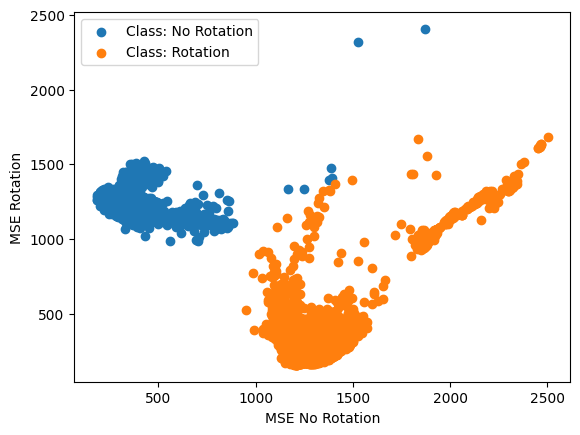

In [32]:
plt.scatter(mse_norot['MSE'].apply(lambda x: x[0]),mse_norot['MSE'].apply(lambda x: x[1]),label = 'Class: No Rotation')
plt.scatter(mse_rot['MSE'].apply(lambda x: x[0]),mse_rot['MSE'].apply(lambda x: x[1]),label = 'Class: Rotation')
# Plot TYPE MSE ROTATIO with VALUE MSE (Y axis)

plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

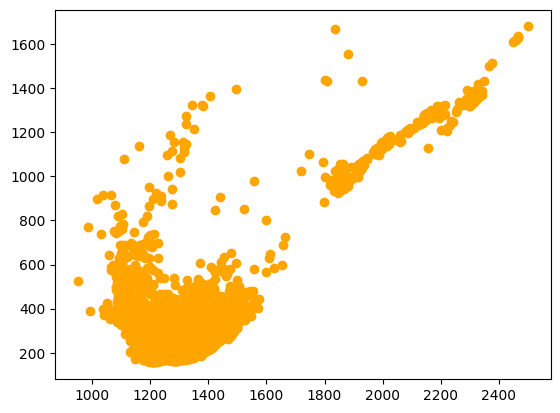

In [33]:
plt.scatter(np.array(mse_rot['MSE'].apply(lambda x: x[0])),np.array(mse_rot['MSE'].apply(lambda x: x[1])),color = 'orange',label = 'Class: Rotation')

# Original Fly Trace

In [34]:
# data source
print("Does the text file exist: ",os.path.exists(txt_data))
# female fly heading and led position data
df_fem_static = pd.read_csv(txt_data , names = ['time','fly heading','led position'],sep = " ")
# compute change over time
df_fem_static['delta-t'] = df_fem_static['time'] - df_fem_static['time'][0] 
# compute LED position in degrees
df_fem_static['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fem_static['led position'])) 
# get the experimental sub groups
fly_dict = sub_exp_groupv2(df_fem_static)
fly_dict



Does the text file exist:  True


{'cali': (0, 6),
 'dark_1': (6, 921),
 'static_1': (921, 2740),
 'static_2': (2740, 4518),
 'static_3': (4518, 6214),
 'static_4': (6214, 7966),
 'dark_2': (7966, 8861)}

Text(0, 0.5, 'Heading/LED Angle')

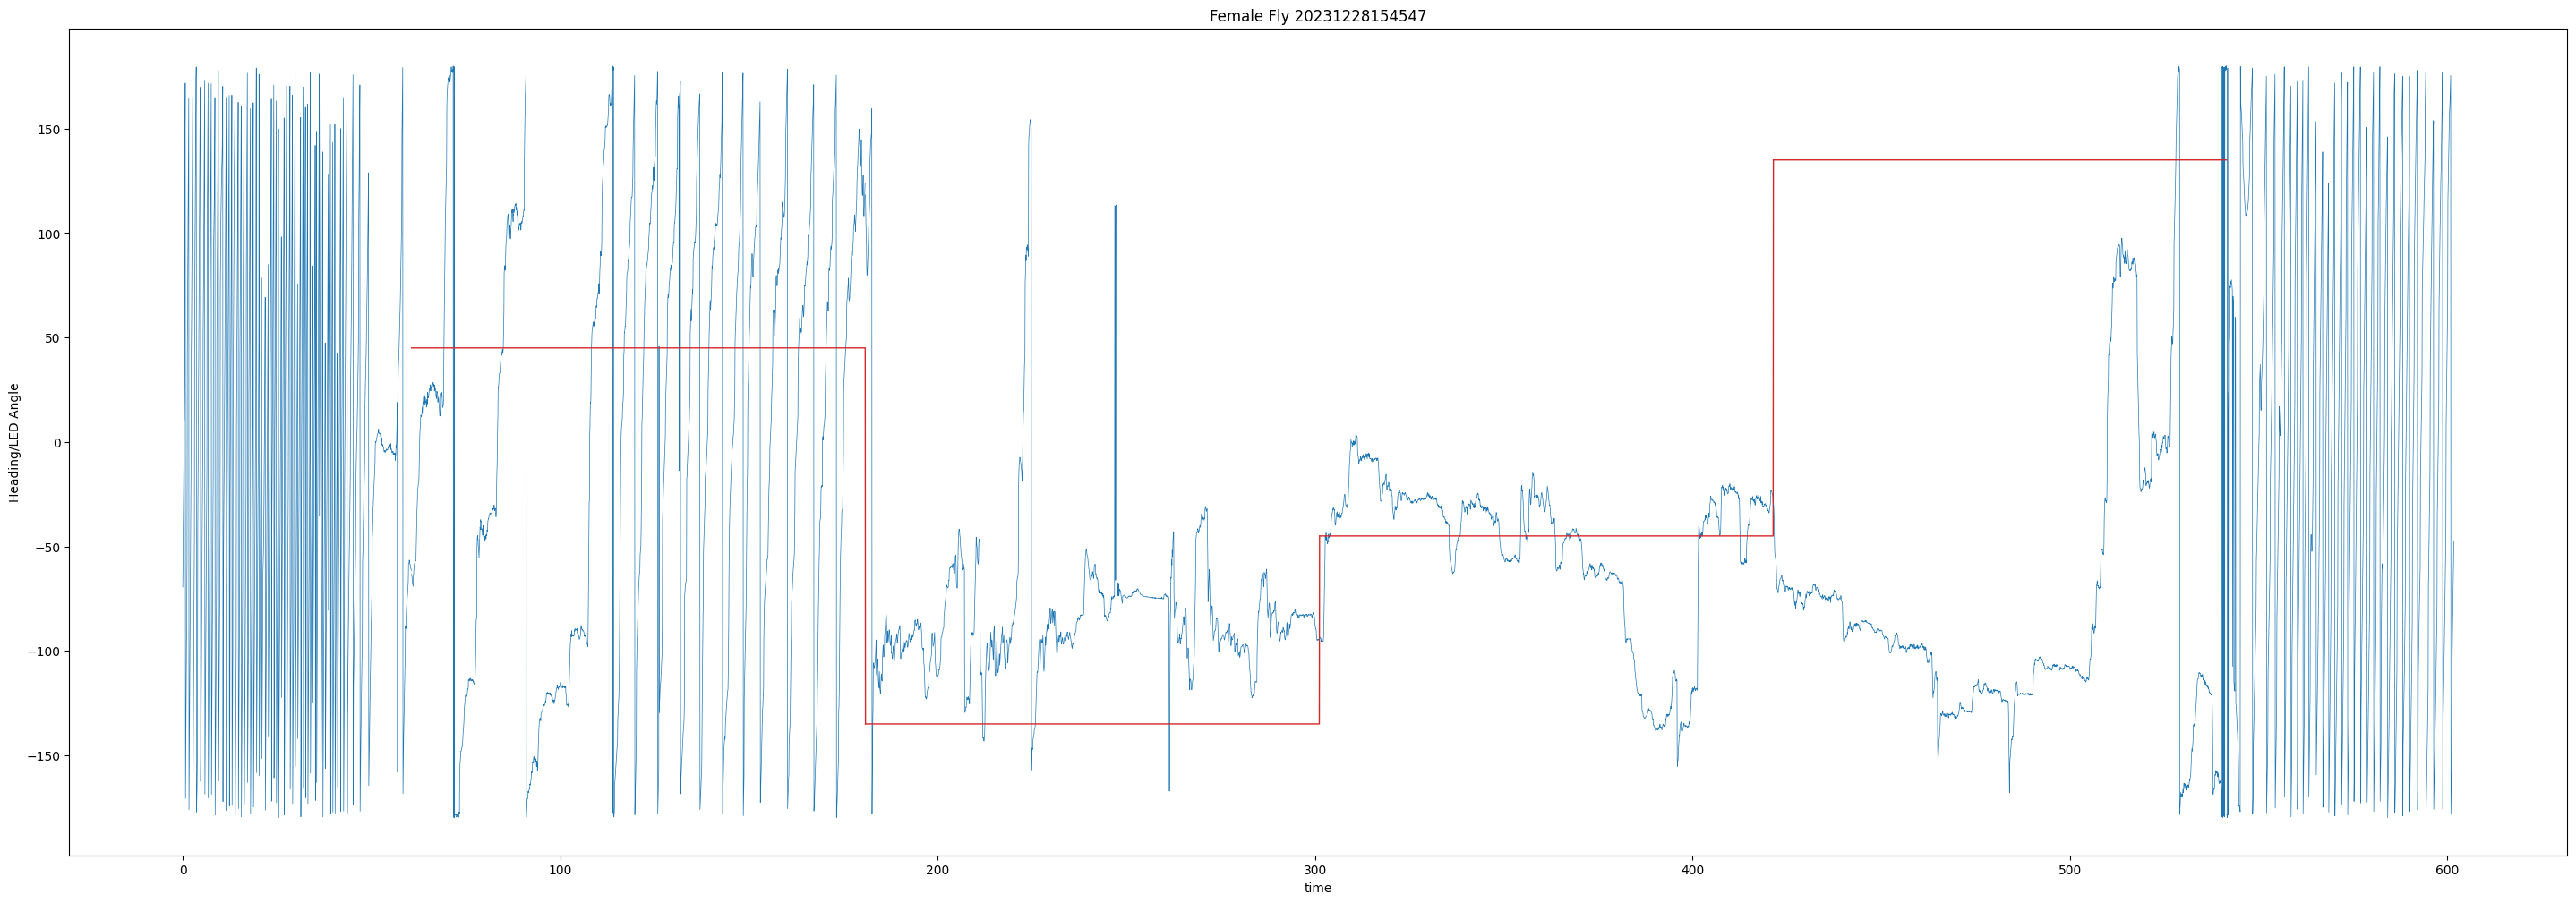

In [35]:
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict.keys()):
    start = fly_dict[k][0]
    end = fly_dict[k][1]
    # print(start,end)
    plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_static['delta-t'][start:end+1],df_fem_static['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231228154547")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

# Reestablish a new Textfile 
dataframe to textfile

In [36]:
# To the dataframe add the LED positions and the time values from the original textfile...
led_pos = df_fem_static['led position']
time_txt = df_fem_static['time']
results_df = results_df.sort_values(by='file')
results_df =results_df.reset_index(drop = True)
# Sort by time
results_df


file          type  \
0     20240502125110_0001  MSE Rotation   
1     20240502125110_0002  MSE Rotation   
2     20240502125110_0003  MSE Rotation   
3     20240502125110_0004  MSE Rotation   
4     20240502125110_0005  MSE Rotation   
...                   ...           ...   
8857  20240502125110_8858  MSE Rotation   
8858  20240502125110_8859  MSE Rotation   
8859  20240502125110_8860  MSE Rotation   
8860  20240502125110_8861  MSE Rotation   
8861  20240502125110_8862  MSE Rotation   

                                           MSE  Original Angle  Adjusted Angle  
0       (1453.5356568246525, 632.973590644097)      110.494410      -69.505590  
1      (1465.3065442552074, 556.6185119635418)      122.725043      -57.274957  
2       (1444.838469116319, 609.9724121024301)      139.997312      -40.002688  
3       (1372.428313560763, 607.1519269635417)      152.674577      -27.325423  
4       (1418.36950585243, 483.22586842187513)      167.958205      -12.041795  
...                                        ...             ...             ...  
8857  (1284.9200048107632, 229.40954731076394)      104.195241      -75.804759  
8858  (1297.0816430746522, 232.42316244965278)      113.055809      -66.944191  
8859  (1304.2610966163193, 252.59791043576388)      121.662466      -58.337534  
8860  (1278.7641757135414, 300.09582633854166)      132.330784      -47.669216  
8861    (1289.57490335243, 259.20984238020833)      140.053228      -39.946772  

[8862 rows x 5 columns]

In [37]:
results_df['time'] = time_txt
results_df['led position'] = led_pos
results_df

file          type  \
0     20240502125110_0001  MSE Rotation   
1     20240502125110_0002  MSE Rotation   
2     20240502125110_0003  MSE Rotation   
3     20240502125110_0004  MSE Rotation   
4     20240502125110_0005  MSE Rotation   
...                   ...           ...   
8857  20240502125110_8858  MSE Rotation   
8858  20240502125110_8859  MSE Rotation   
8859  20240502125110_8860  MSE Rotation   
8860  20240502125110_8861  MSE Rotation   
8861  20240502125110_8862  MSE Rotation   

                                           MSE  Original Angle  \
0       (1453.5356568246525, 632.973590644097)      110.494410   
1      (1465.3065442552074, 556.6185119635418)      122.725043   
2       (1444.838469116319, 609.9724121024301)      139.997312   
3       (1372.428313560763, 607.1519269635417)      152.674577   
4       (1418.36950585243, 483.22586842187513)      167.958205   
...                                        ...             ...   
8857  (1284.9200048107632, 229.40954731076394)      104.195241   
8858  (1297.0816430746522, 232.42316244965278)      113.055809   
8859  (1304.2610966163193, 252.59791043576388)      121.662466   
8860  (1278.7641757135414, 300.09582633854166)      132.330784   
8861    (1289.57490335243, 259.20984238020833)      140.053228   

      Adjusted Angle          time  led position  
0         -69.505590  1.714679e+09            -1  
1         -57.274957  1.714679e+09            -1  
2         -40.002688  1.714679e+09            -1  
3         -27.325423  1.714679e+09            -1  
4         -12.041795  1.714679e+09            -1  
...              ...           ...           ...  
8857      -75.804759  1.714680e+09           150  
8858      -66.944191  1.714680e+09           150  
8859      -58.337534  1.714680e+09           149  
8860      -47.669216  1.714680e+09           149  
8861      -39.946772  1.714680e+09           149  

[8862 rows x 7 columns]

In [38]:
# COUNT NUMBER OF ROTATIONS...
results_df[results_df['type']=='MSE Rotation']

file          type  \
0     20240502125110_0001  MSE Rotation   
1     20240502125110_0002  MSE Rotation   
2     20240502125110_0003  MSE Rotation   
3     20240502125110_0004  MSE Rotation   
4     20240502125110_0005  MSE Rotation   
...                   ...           ...   
8857  20240502125110_8858  MSE Rotation   
8858  20240502125110_8859  MSE Rotation   
8859  20240502125110_8860  MSE Rotation   
8860  20240502125110_8861  MSE Rotation   
8861  20240502125110_8862  MSE Rotation   

                                           MSE  Original Angle  \
0       (1453.5356568246525, 632.973590644097)      110.494410   
1      (1465.3065442552074, 556.6185119635418)      122.725043   
2       (1444.838469116319, 609.9724121024301)      139.997312   
3       (1372.428313560763, 607.1519269635417)      152.674577   
4       (1418.36950585243, 483.22586842187513)      167.958205   
...                                        ...             ...   
8857  (1284.9200048107632, 229.40954731076394)      104.195241   
8858  (1297.0816430746522, 232.42316244965278)      113.055809   
8859  (1304.2610966163193, 252.59791043576388)      121.662466   
8860  (1278.7641757135414, 300.09582633854166)      132.330784   
8861    (1289.57490335243, 259.20984238020833)      140.053228   

      Adjusted Angle          time  led position  
0         -69.505590  1.714679e+09            -1  
1         -57.274957  1.714679e+09            -1  
2         -40.002688  1.714679e+09            -1  
3         -27.325423  1.714679e+09            -1  
4         -12.041795  1.714679e+09            -1  
...              ...           ...           ...  
8857      -75.804759  1.714680e+09           150  
8858      -66.944191  1.714680e+09           150  
8859      -58.337534  1.714680e+09           149  
8860      -47.669216  1.714680e+09           149  
8861      -39.946772  1.714680e+09           149  

[6512 rows x 7 columns]

In [39]:
# Time, Angle, Led Position
# Rewrite
results_df.to_csv('revised_file.txt',sep=' ', header=False)


In [40]:
# data source
data_revised ='revised_file.txt'
# os.path.exists('/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt')
# female fly heading and led position data
df_fly_revised= pd.read_csv(data_revised, names = ['filename','type','MSE','Original Angle','Adjusted Angle','time','led position'],sep = " ")

# compute change over time
df_fly_revised['delta-t'] = df_fly_revised['time'] - df_fly_revised['time'][0] 

# compute LED position in degrees
df_fly_revised['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fly_revised['led position'])) 

# print(cali_led_pos(df_fem_static))
# print(all_dark_led_pos(df_fem_static))
# print(all_static_led_pos(df_fem_static))
# print(all_loop_led_pos(df_fem_static))
fly_dict_revised = sub_exp_groupv2(df_fly_revised)
fly_dict_revised

{'cali': (0, 6),
 'dark_1': (6, 921),
 'static_1': (921, 2740),
 'static_2': (2740, 4518),
 'static_3': (4518, 6214),
 'static_4': (6214, 7966),
 'dark_2': (7966, 8861)}

([<matplotlib.axis.YTick at 0x7f35c630d9d0>,
 [Text(0, -180, '−180'),
  Text(0, -90, '−90'),
  Text(0, 0, '0'),
  Text(0, 90, '90'),
  Text(0, 180, '180')])

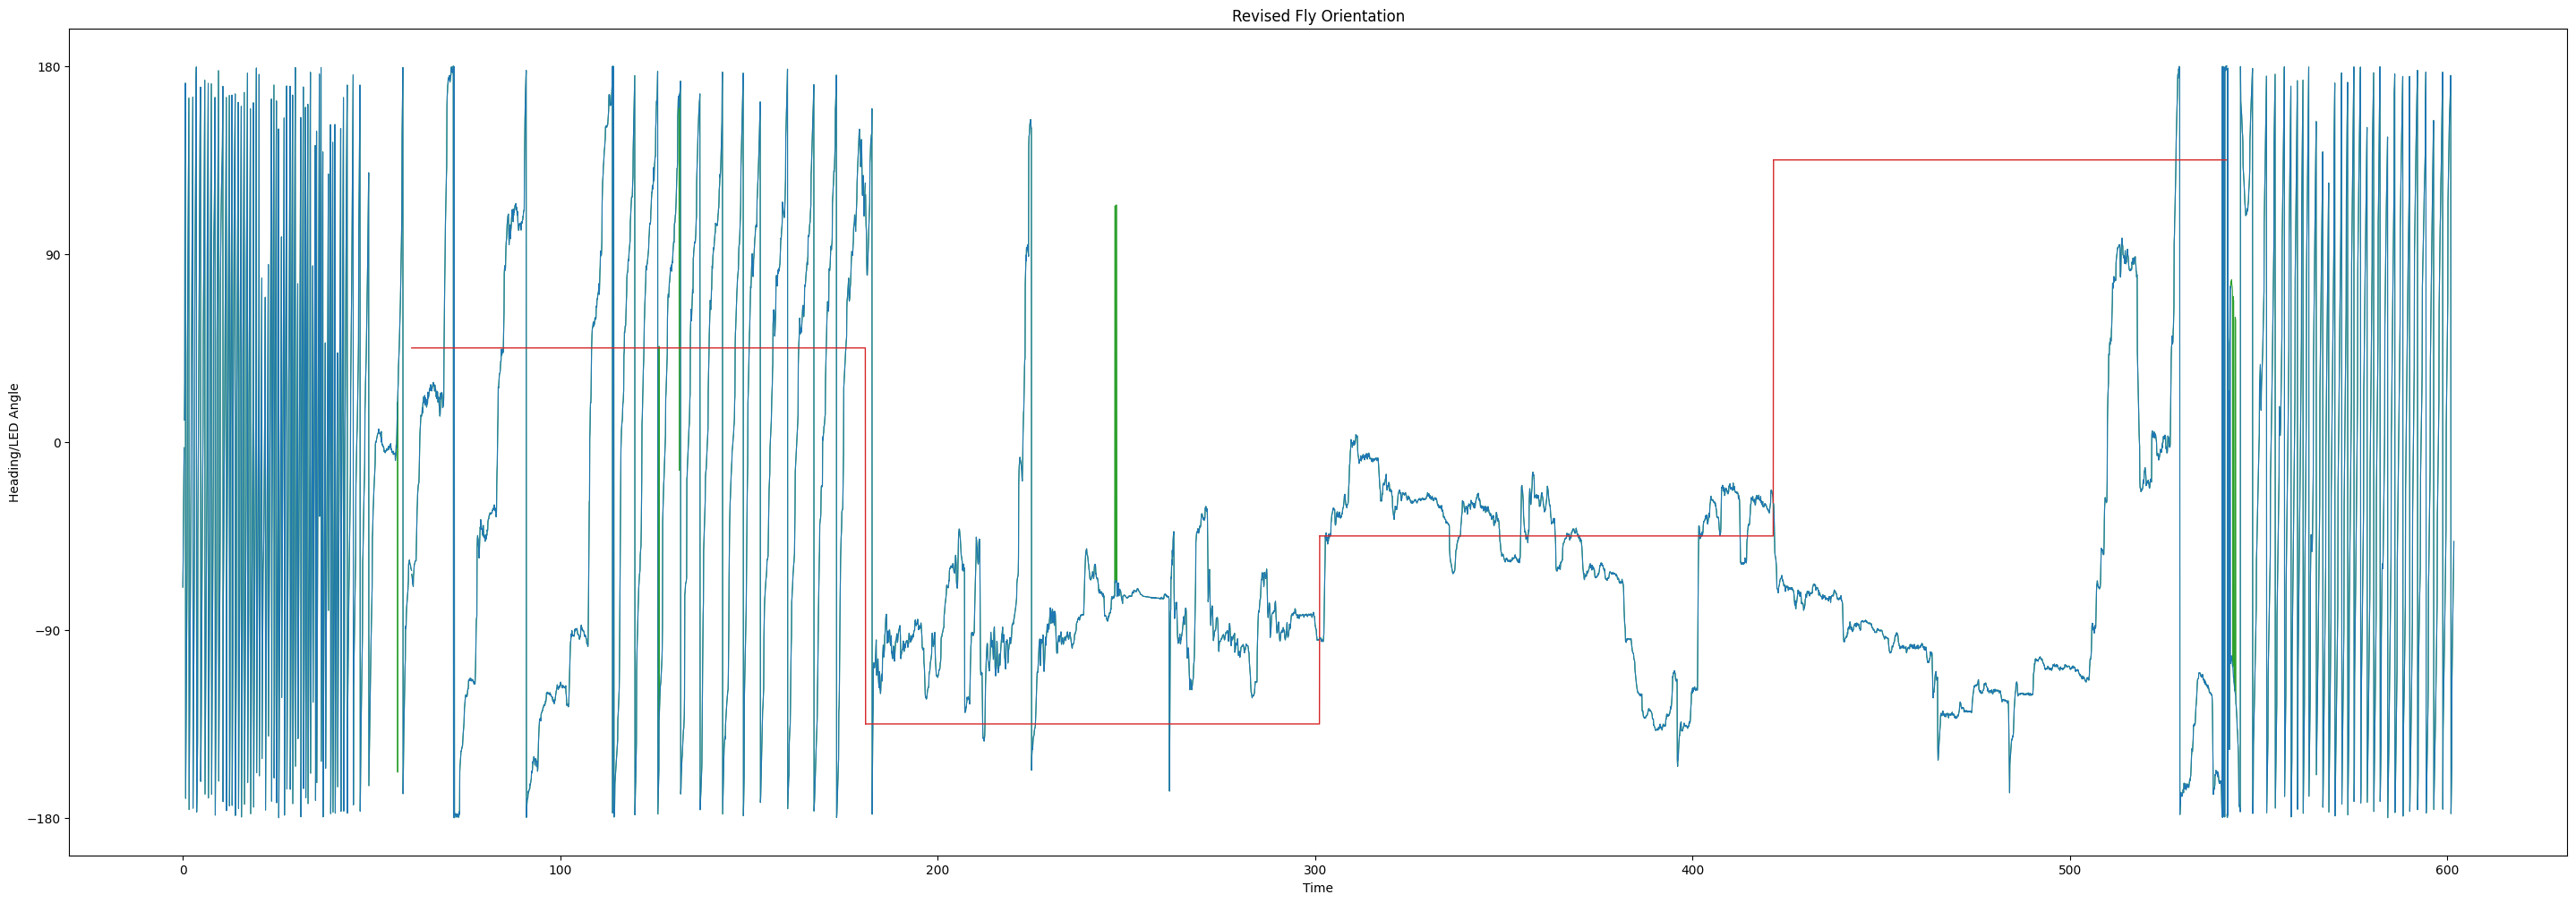

In [45]:
# plotting the revised textfile
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict_revised.keys()):
    start = fly_dict_revised[k][0]
    end = fly_dict_revised[k][1]
    # print(start,end)
    # original textfile data
    plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:green', linewidth = .8, label = 'Heading')
    # revised data
    plt.plot(df_fly_revised['delta-t'][start:end],df_fly_revised['Adjusted Angle'][start:end],color = 'tab:blue', linewidth = .8, label = 'Heading')
    plt.plot(df_fly_revised['delta-t'][start:end+1],df_fly_revised['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Revised Fly Orientation")
plt.xlabel("Time")
plt.ylabel("Heading/LED Angle")
plt.yticks(np.arange(-180,181,90))

# New vs Original Plot

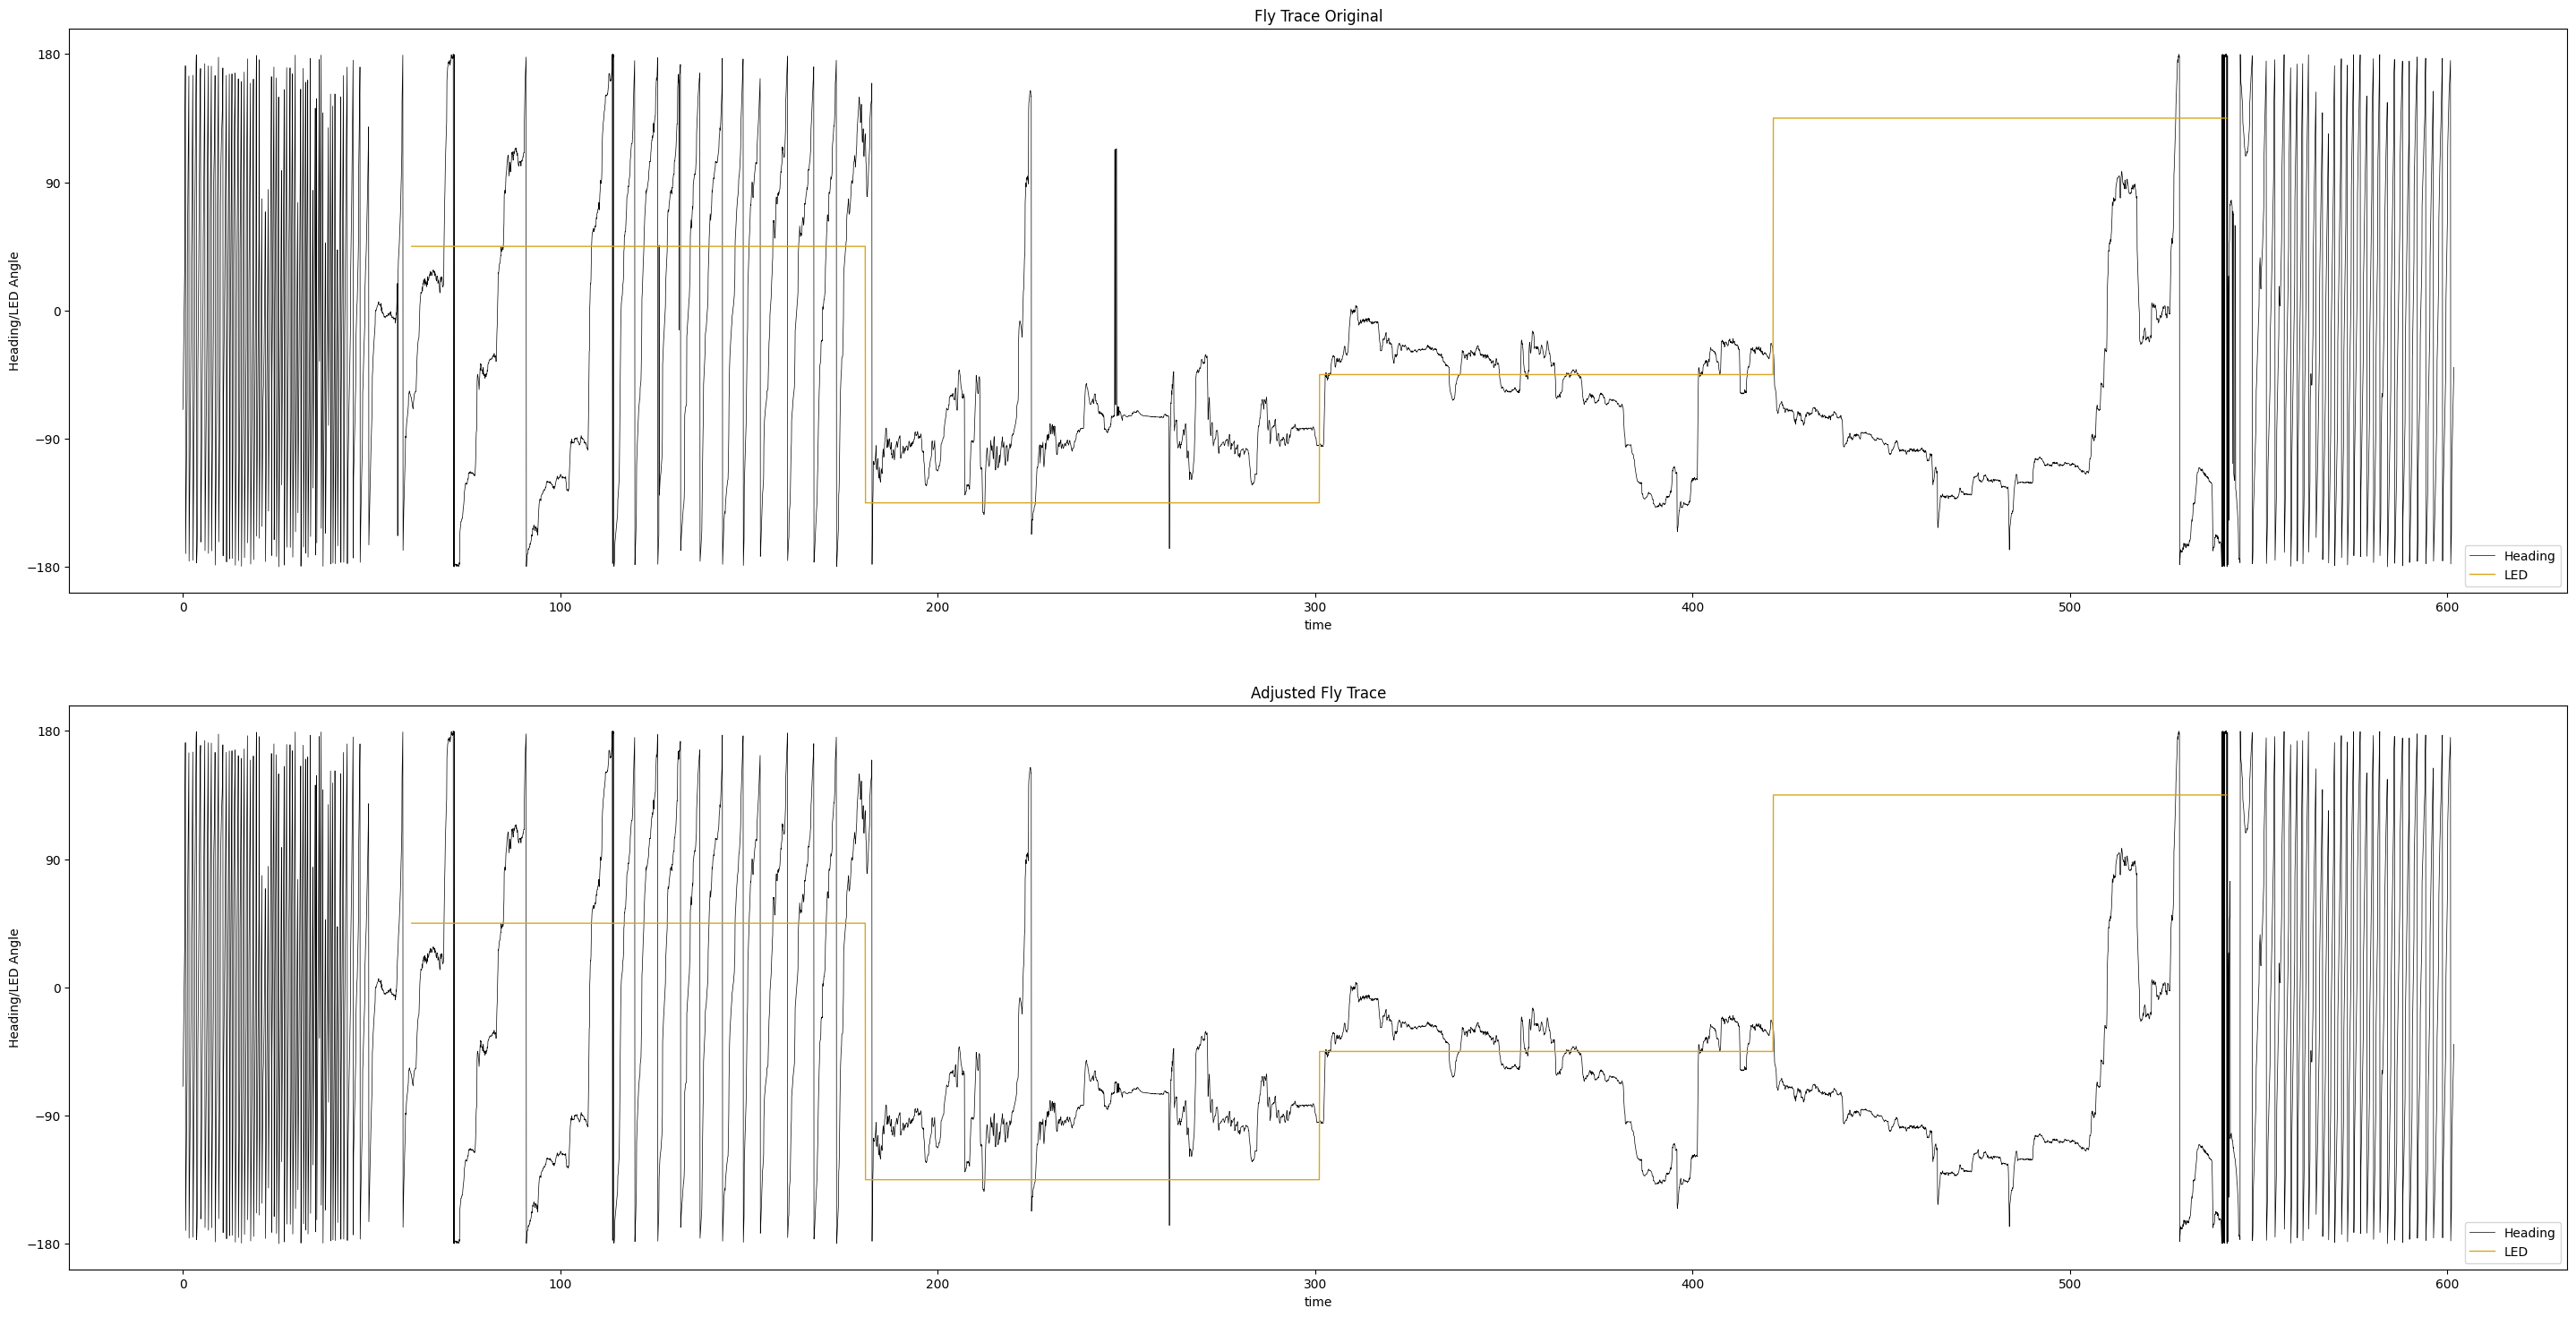

In [50]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(36,18))

# Main Plot 
# ax1.plot(df_fly_revised['delta-t'],df_fly_revised['Original Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax1.plot(df_fem_static['delta-t'],df_fem_static['fly heading'],color = 'k', linewidth = .5, label = 'Heading')
ax1.plot(df_fem_static['delta-t'],df_fem_static['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax1.set_title("Fly Trace Original")
ax1.set_xlabel("time")
ax1.set_ylabel("Heading/LED Angle")
ax1.set_yticks(np.arange(-180,181,90))
ax1.legend(loc = "lower right")

# Offset
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['Adjusted Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax2.set_title("Adjusted Fly Trace")
ax2.set_xlabel("time")
ax2.set_ylabel("Heading/LED Angle")
ax2.set_yticks(np.arange(-180,181,90))
ax2.legend(loc = "lower right")

# Save Figure
# plt.savefig('figs/adjvsorig.svg',facecolor = 'white')

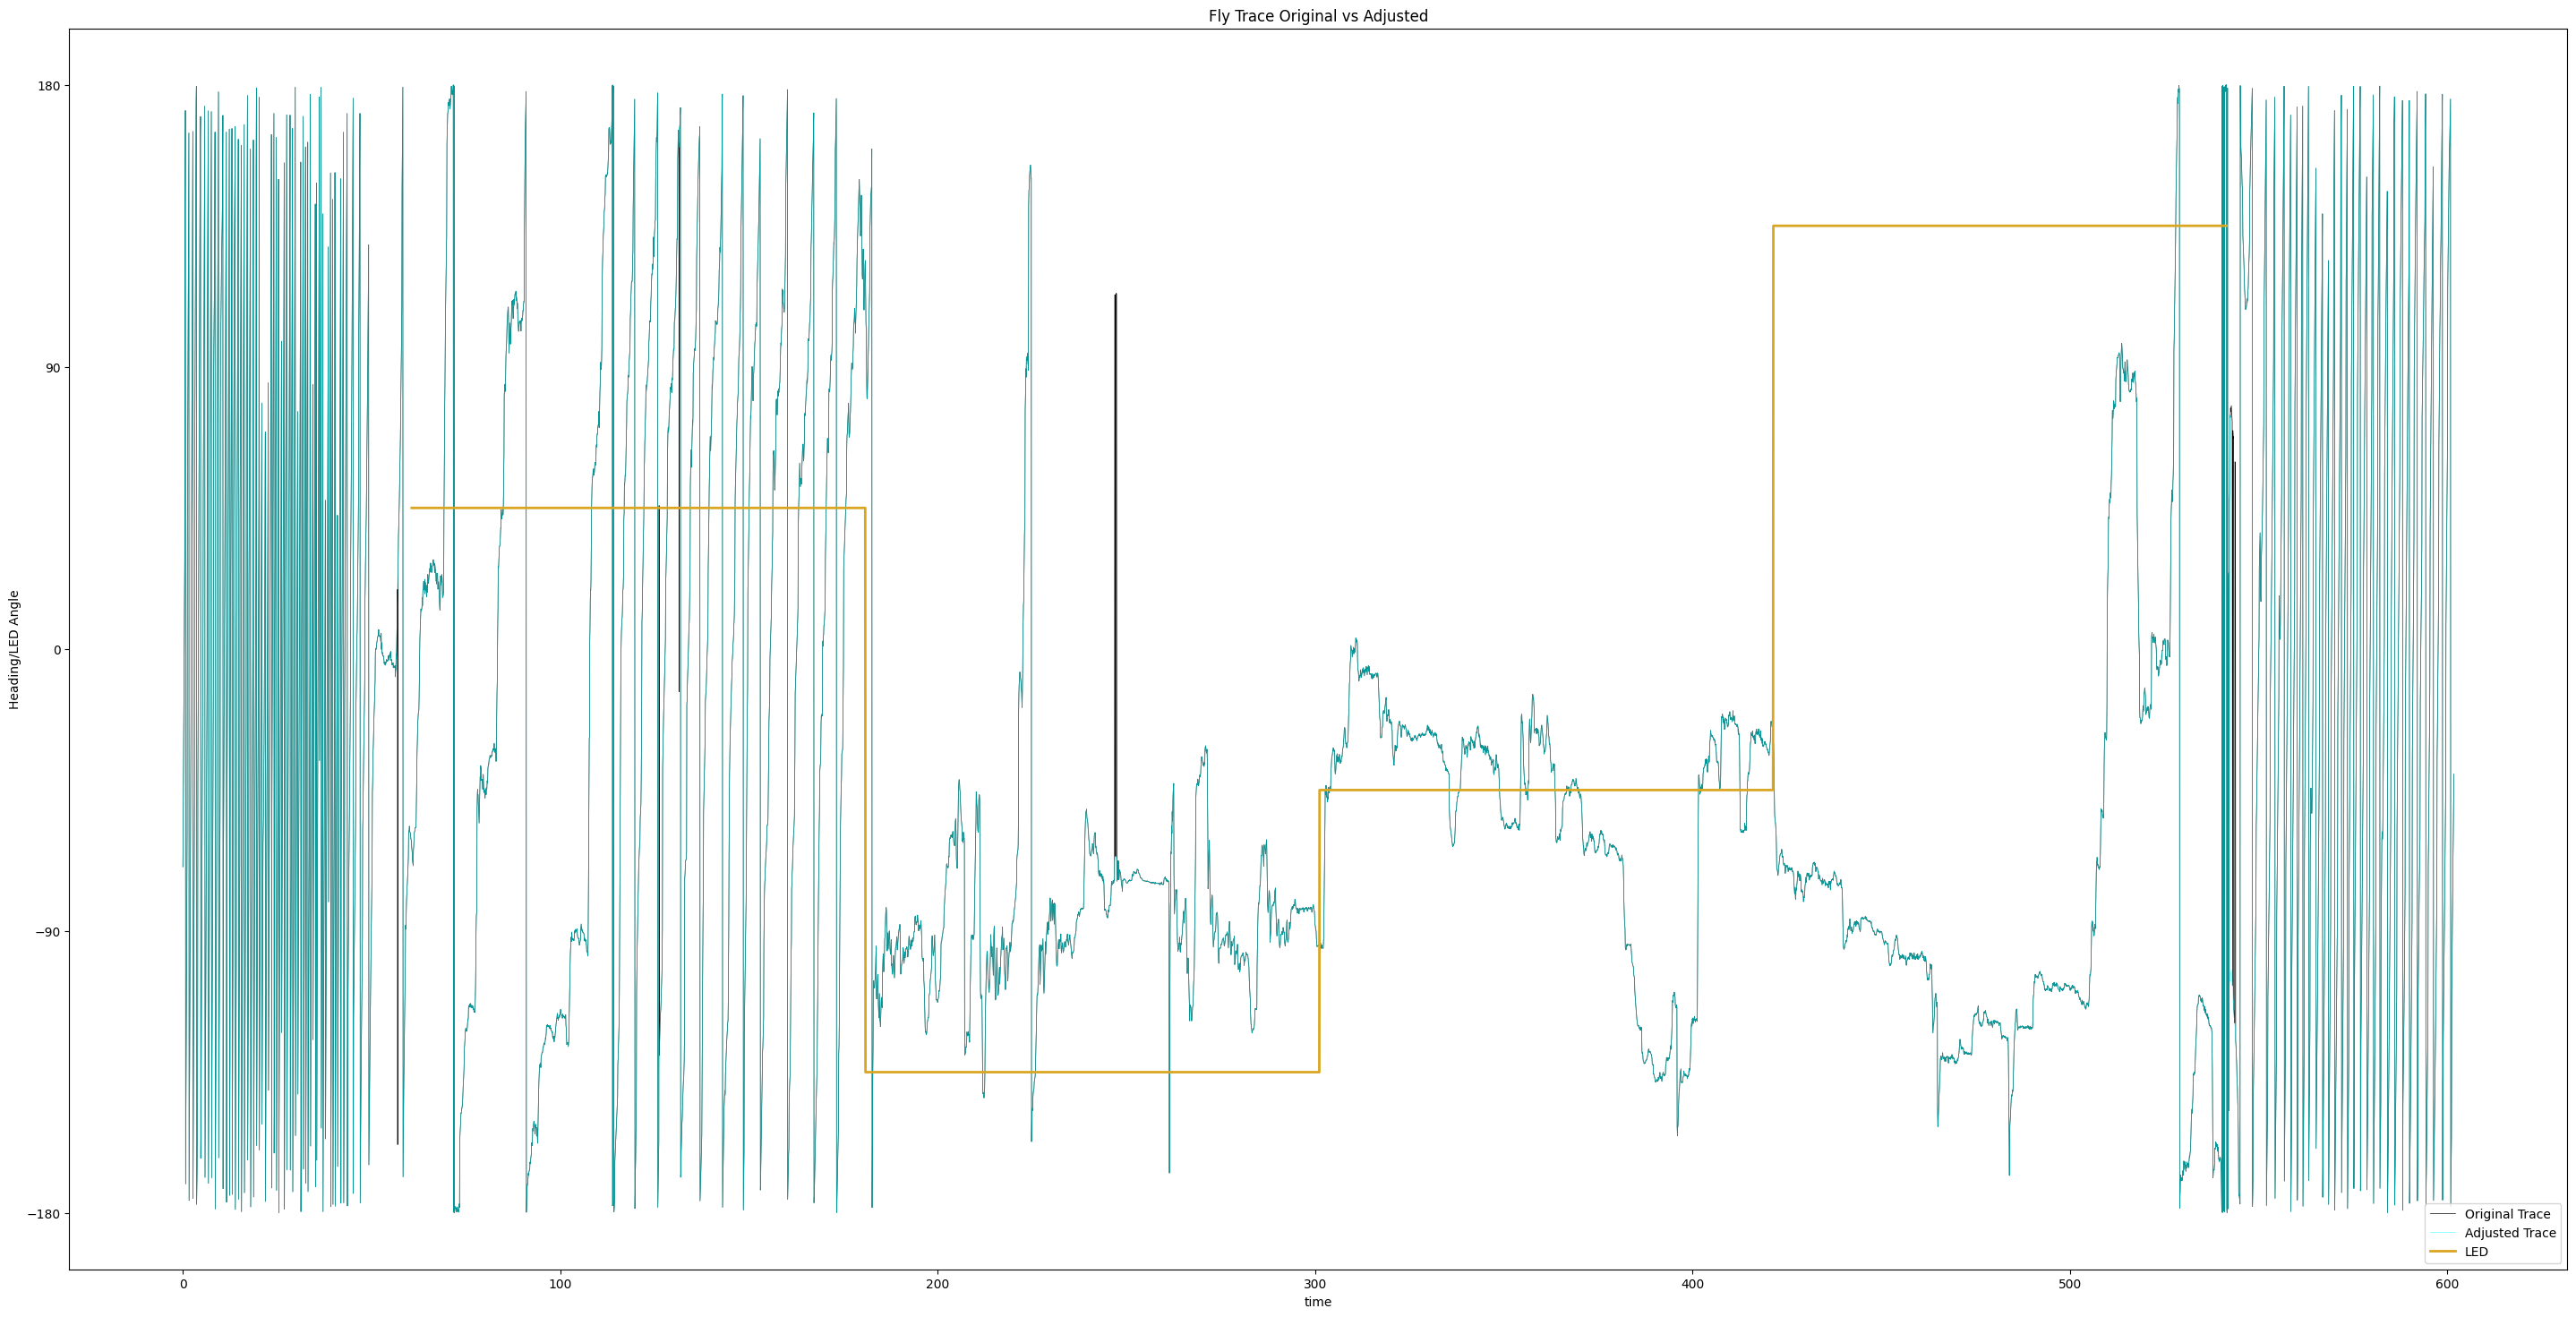

In [52]:
plt.figure(figsize=(36,18))

# Main Plot 
plt.plot(df_fem_static['delta-t'],df_fem_static['fly heading'],color = 'k',linewidth = .5, label = 'Original Trace') # txt file data
plt.plot(df_fly_revised['delta-t'],df_fly_revised['Adjusted Angle'],color = 'cyan',alpha=.6,linewidth = .5, label = 'Adjusted Trace') # adjusted angle
plt.plot(df_fly_revised['delta-t'],df_fly_revised['led angle'],color = 'goldenrod', linewidth = 2, label = 'LED')
plt.title("Fly Trace Original vs Adjusted")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")
plt.yticks(np.arange(-180,181,90))
plt.legend(loc = "lower right")

# Save Figure
# plt.savefig('figs/adj_vs_orig2.svg',facecolor = 'white')

## Ensure that Original and Adjusted Headings Account for the Wrapping Affect...

[  11   25   41   55   72   89  103  116  131  145  163  177  189  200
  213  226  238  250  263  275  287  299  310  321  335  347  360  370
  380  389  401  412  422  436  446  457  467  479  489  498  507  517
  527  537  539  542  553  560  567  577  589  598  607  616  626  639
  650  665  689  716  751  887 1087 1090 1091 1379 1722 1724 1727 1811
 1904 1996 2074 2165 2249 2318 2428 2534 2624 2767 3395 7780 7947 7949
 7950 7951 7954 7955 7956 7957 7958 7966 7969 7970 7976 7980 8017 8066
 8121 8155 8192 8218 8244 8266 8289 8319 8345 8369 8393 8420 8443 8468
 8494 8520 8546 8571 8601 8630 8662 8689 8720 8751 8781 8817 8849]
11 25
25 41
41 55
55 72
72 89
89 103
103 116
116 131
131 145
145 163
163 177
177 189
189 200
200 213
213 226
226 238
238 250
250 263
263 275
275 287
287 299
299 310
310 321
321 335
335 347
347 360
360 370
370 380
380 389
389 401
401 412
412 422
422 436
436 446
446 457
457 467
467 479
479 489
489 498
498 507
507 517
517 527
527 537
537 539
539 542
542 553
553 560


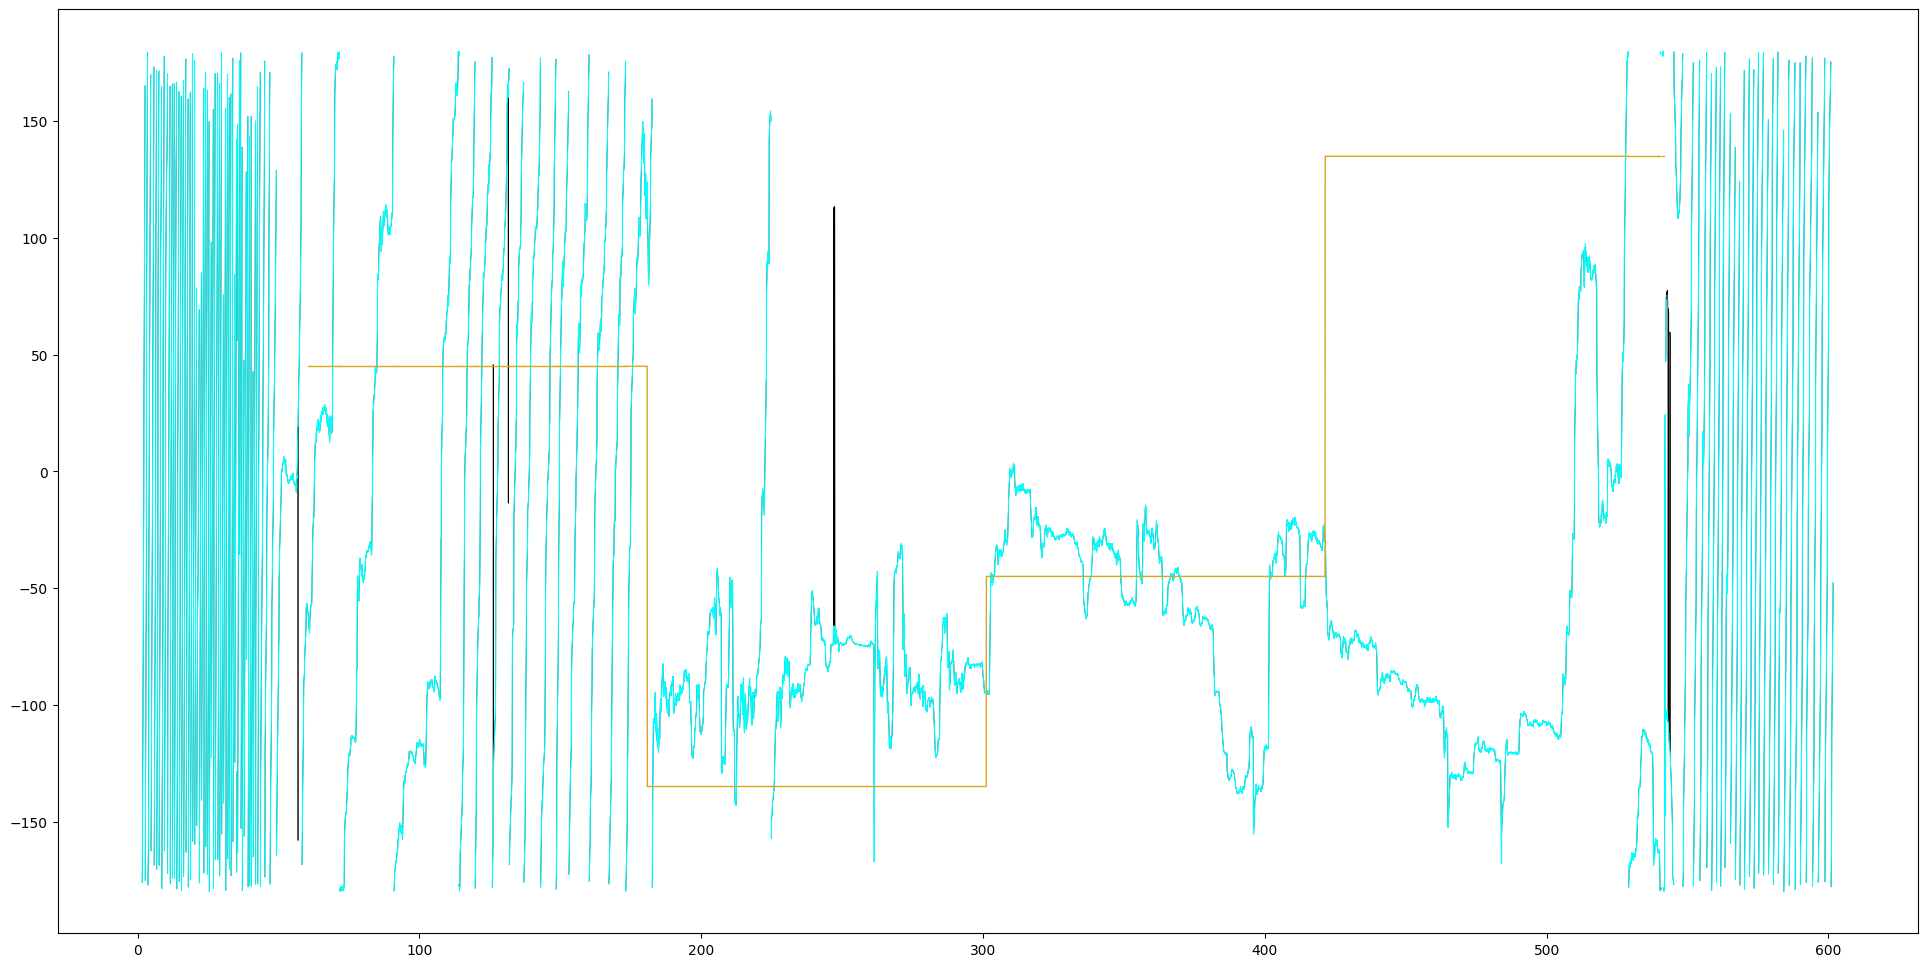

In [54]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot()
split_idx = []
split_idx = (np.where(np.abs(np.diff(df_fly_revised['Adjusted Angle']))>179)[0]+1)
print(split_idx)
sub_idx_groups = []
if len(split_idx>0):
    for count,i in enumerate(split_idx):
        if count == 0:
            sub_idx_groups.append([start,i])
        elif count == len(split_idx) -1:
            sub_idx_groups.append([i,end])
        else:
            sub_idx_groups.append([i,split_idx[count+1]])
    for group_idx in range(1,len(sub_idx_groups)):
        print(split_idx[group_idx-1],split_idx[group_idx])
    # Now what will be done is to rest this data so that it can just be directly plotted by filling in the proper interpolated value..
    # f = interpolate.interp1d(df_male_dat['delta-t'], df_male_dat['fly heading'], kind = 'cubic')
    ## basically doubled the number of points...\n",
    # xnew = np.linspace(df_male_dat['delta-t'].loc[0],df_male_dat['delta-t'].loc[len(df_male_dat['delta-t'])-1],20000)
    # ynew = f(xnew)   # use interpolation function returned by `interp1d`\n",
else:
    # f = interpolate.interp1d(df_fem_loop['delta-t'],df_fem_loop['fly heading'], kind='cubic')


    sub_idx_groups = [[start,end]]

for k_sub in range(len(sub_idx_groups)):
    start_k = sub_idx_groups[k_sub][0]
    end_k = sub_idx_groups[k_sub][1]
    ax1.plot(df_fem_static['delta-t'][start_k:end_k],df_fem_static['fly heading'][start_k:end_k],color = 'k',linewidth = .5, label = 'Original Trace')
    ax1.plot(df_fly_revised['delta-t'][start_k:end_k],df_fly_revised['Adjusted Angle'][start_k:end_k],color = 'cyan', linewidth = .8, label = 'Adjusted Heading')
    ax1.plot(df_fly_revised['delta-t'][start_k:end_k],df_fly_revised['led angle'][start_k:end_k],color = 'goldenrod', linewidth = 1, label = 'LED')
    # ax1.plot(df_fly_revised['delta-t'][start_k:end_k],df_fly_revised['Original Angle'][start_k:end_k],color = 'k', linewidth = .8, label = 'Heading')

# EXTRAS

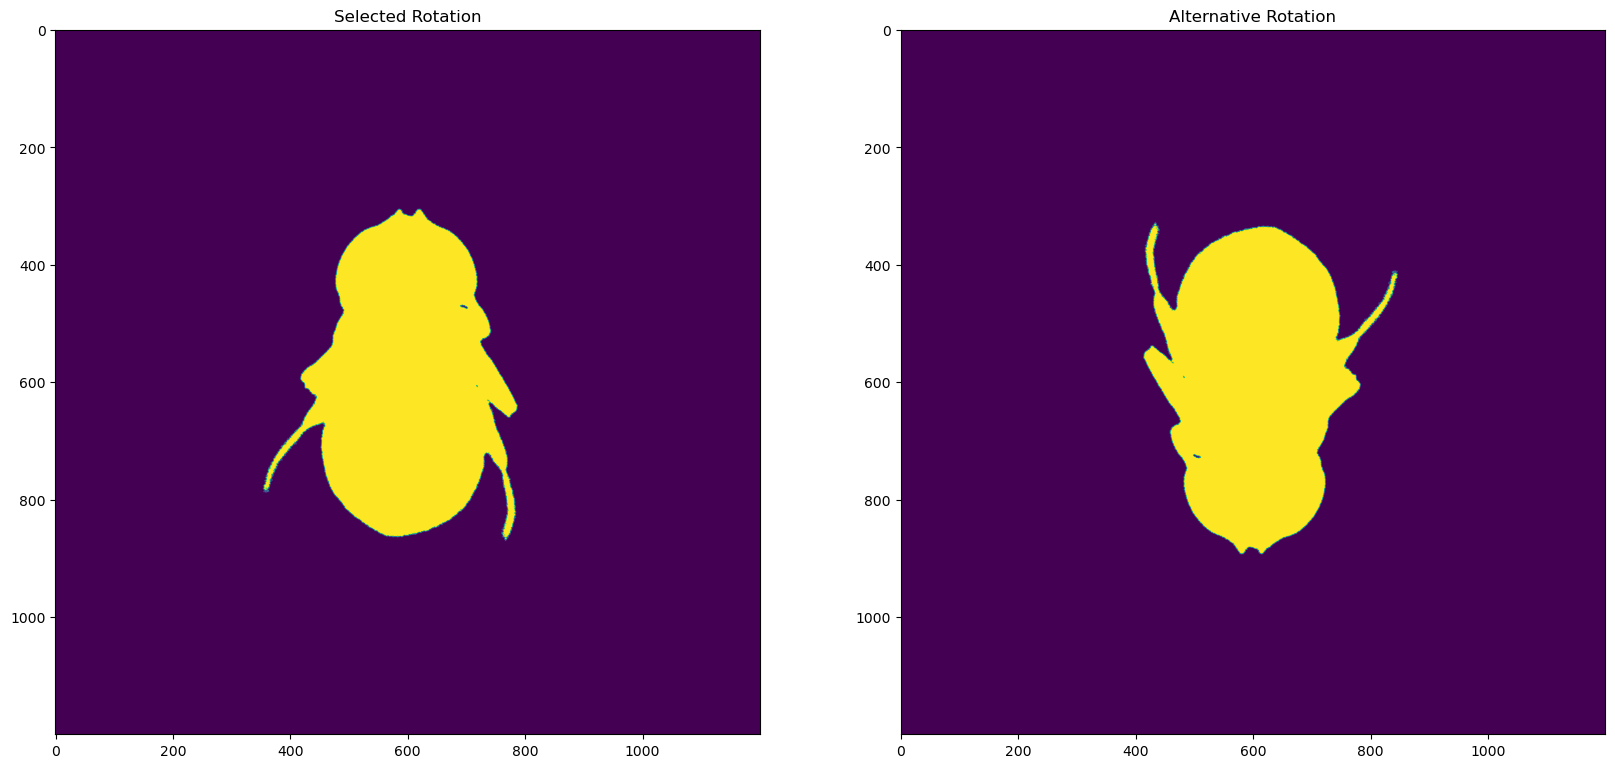

In [42]:
## Test Image (18th image in the stack)
img1 = imgs[list(imgs.keys())[18]].astype('float64')
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Selected Rotation")
plt.imshow(img1) 
plt.subplot(122)
plt.title("Alternative Rotation")
plt.imshow(cv2.rotate(img1,cv2.ROTATE_180))

In [43]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 255.10822447569433
Rotation: 1138.383849197916


In [20]:
fly_mask_hrz = fly_mask_hrz.astype('float64')
error = mse(avg_mask,fly_mask_hrz)
error2 = mse(avg_mask,cv2.rotate(fly_mask_hrz,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 1946.0575228090283
Rotation: 1709.1743328090274
